In [1]:
# 🔸 Fase 2 – Comprensión de datos (EDA inicial: agregaciones y agrupaciones)
# Configuración optimizada de Spark Session para análisis EDA

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Configurar Spark con características similares a Fase 1
spark = SparkSession.builder \
    .appName("MEF_EDA_Analysis_Phase2") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.adaptive.advisoryPartitionSizeInBytes", "128MB") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.adaptive.skewJoin.enabled", "true") \
    .getOrCreate()

print("Spark Session configurada para EDA - Fase 2")
print(f"Aplicación: {spark.sparkContext.appName}")
print(f"Memoria Driver: {spark.conf.get('spark.driver.memory')}")

# Configurar estilo de visualizaciones
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Librerías de visualización configuradas")


Spark Session configurada para EDA - Fase 2
Aplicación: MEF_EDA_Analysis_Phase2
Memoria Driver: 8g
Librerías de visualización configuradas


In [2]:

df_full = spark.read.parquet("raw_temp_parquet/year")
#df = df_full.sample(fraction=0.001, seed=42)  # Solo 0.1% de los datos
df = df_full

# Verificar carga exitosa
total_records = df.count()
print(f" Registros en la muestra: {total_records:,}")
print(f"  Columnas disponibles: {len(df.columns)}")

# Verificar años disponibles en la muestra
years_df = df.select("ANO_EJE").distinct().orderBy("ANO_EJE")
years_list = [row['ANO_EJE'] for row in years_df.collect()]
print(f" Años en la muestra: {years_list}")

# Schema básico
print(f"\n Columnas principales para EDA:")
key_columns = ["ANO_EJE", "MONTO_PIM", "MONTO_DEVENGADO", "SECTOR_NOMBRE", 
               "PLIEGO_NOMBRE", "DEPARTAMENTO_EJECUTORA_NOMBRE"]
for col in key_columns:
    if col in df.columns:
        print(f"    {col}")
    else:
        print(f"    {col} - NO ENCONTRADA")



 Registros en la muestra: 40,173,892
  Columnas disponibles: 63
 Años en la muestra: [2022, 2023, 2024, 2025]

 Columnas principales para EDA:
    ANO_EJE
    MONTO_PIM
    MONTO_DEVENGADO
    SECTOR_NOMBRE
    PLIEGO_NOMBRE
    DEPARTAMENTO_EJECUTORA_NOMBRE


 ANÁLISIS 1: TOTALES ANUALES DE PRESUPUESTO Y EJECUCIÓN
 Totales por año (en millones de soles):
    2022: S/ 237,821M presupuestado | S/ 209,323M ejecutado | 10,539,505 registros
    2023: S/ 249,947M presupuestado | S/ 223,060M ejecutado | 10,740,188 registros
    2024: S/ 262,058M presupuestado | S/ 238,990M ejecutado | 11,188,735 registros
    2025: S/ 266,214M presupuestado | S/ 158,685M ejecutado | 7,705,464 registros


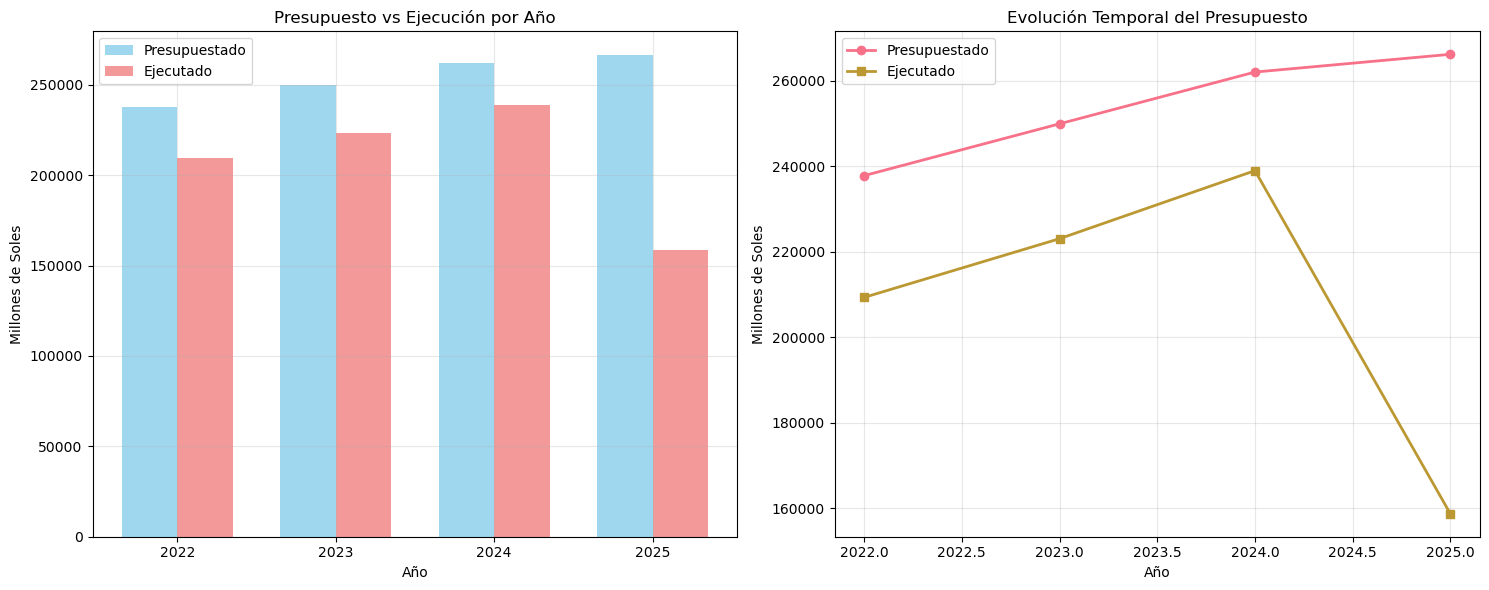

In [3]:
#  Totales de presupuesto y ejecución por año
print("=" * 60)
print(" ANÁLISIS 1: TOTALES ANUALES DE PRESUPUESTO Y EJECUCIÓN")
print("=" * 60)

# Calcular totales agregados por año
totales_anuales = df.groupBy("ANO_EJE") \
    .agg(
        F.sum("MONTO_PIM").alias("PRESUPUESTO_TOTAL"),
        F.sum("MONTO_DEVENGADO").alias("EJECUTADO_TOTAL"),
        F.sum("MONTO_CERTIFICADO").alias("CERTIFICADO_TOTAL"),
        F.sum("MONTO_COMPROMETIDO").alias("COMPROMETIDO_TOTAL"),
        F.count("*").alias("NUM_REGISTROS")
    ) \
    .orderBy("ANO_EJE")

# Mostrar resultados
print(" Totales por año (en millones de soles):")
totales_pd = totales_anuales.toPandas()
for _, row in totales_pd.iterrows():
    año = int(row['ANO_EJE'])
    presupuesto = row['PRESUPUESTO_TOTAL'] / 1_000_000
    ejecutado = row['EJECUTADO_TOTAL'] / 1_000_000
    registros = int(row['NUM_REGISTROS'])
    print(f"    {año}: S/ {presupuesto:,.0f}M presupuestado | S/ {ejecutado:,.0f}M ejecutado | {registros:,} registros")

# Crear visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Presupuesto vs Ejecutado por año
years = totales_pd['ANO_EJE']
presupuesto_millones = totales_pd['PRESUPUESTO_TOTAL'] / 1_000_000
ejecutado_millones = totales_pd['EJECUTADO_TOTAL'] / 1_000_000

x = np.arange(len(years))
width = 0.35

ax1.bar(x - width/2, presupuesto_millones, width, label='Presupuestado', alpha=0.8, color='skyblue')
ax1.bar(x + width/2, ejecutado_millones, width, label='Ejecutado', alpha=0.8, color='lightcoral')

ax1.set_xlabel('Año')
ax1.set_ylabel('Millones de Soles')
ax1.set_title('Presupuesto vs Ejecución por Año')
ax1.set_xticks(x)
ax1.set_xticklabels(years)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Evolución temporal
ax2.plot(years, presupuesto_millones, marker='o', linewidth=2, label='Presupuestado')
ax2.plot(years, ejecutado_millones, marker='s', linewidth=2, label='Ejecutado')
ax2.set_xlabel('Año')
ax2.set_ylabel('Millones de Soles')
ax2.set_title('Evolución Temporal del Presupuesto')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




 ANÁLISIS 2: PORCENTAJE DE EJECUCIÓN ANUAL
 Eficiencia de ejecución por año:
    2022: 88.0% de ejecución - 🟡 Bueno
    2023: 89.2% de ejecución - 🟡 Bueno
    2024: 91.2% de ejecución - 🟢 Excelente
    2025: 59.6% de ejecución - 🔴 Bajo


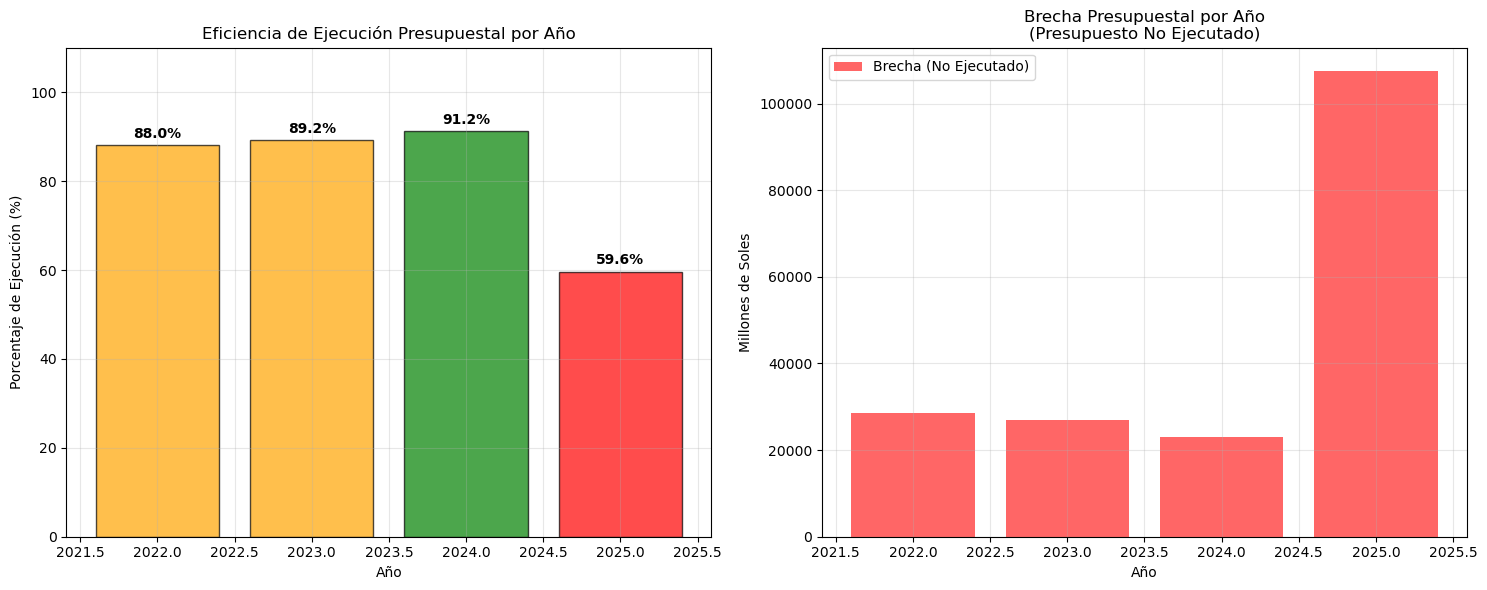


 ESTADÍSTICAS DE EJECUCIÓN:
   • Promedio de ejecución: 82.0%
   • Mejor año: 2024 con 91.2%
   • Peor año: 2025 con 59.6%


In [4]:
#  Porcentaje de ejecución anual
print("=" * 60)
print(" ANÁLISIS 2: PORCENTAJE DE EJECUCIÓN ANUAL")
print("=" * 60)

# Calcular porcentaje de ejecución por año
ejecucion_anual = totales_anuales.withColumn(
    "PORCENTAJE_EJECUCION", 
    (F.col("EJECUTADO_TOTAL") / F.col("PRESUPUESTO_TOTAL") * 100)
).select("ANO_EJE", "PRESUPUESTO_TOTAL", "EJECUTADO_TOTAL", "PORCENTAJE_EJECUCION")

print(" Eficiencia de ejecución por año:")
ejecucion_pd = ejecucion_anual.toPandas()
for _, row in ejecucion_pd.iterrows():
    año = int(row['ANO_EJE'])
    porcentaje = row['PORCENTAJE_EJECUCION']
    estado = "🟢 Excelente" if porcentaje >= 90 else "🟡 Bueno" if porcentaje >= 75 else "🔴 Bajo"
    print(f"    {año}: {porcentaje:.1f}% de ejecución - {estado}")

# Visualización del porcentaje de ejecución
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Barras de porcentaje de ejecución
colors = ['green' if x >= 90 else 'orange' if x >= 75 else 'red' for x in ejecucion_pd['PORCENTAJE_EJECUCION']]
bars = ax1.bar(ejecucion_pd['ANO_EJE'], ejecucion_pd['PORCENTAJE_EJECUCION'], 
               color=colors, alpha=0.7, edgecolor='black')

# Añadir etiquetas en las barras
for bar, porcentaje in zip(bars, ejecucion_pd['PORCENTAJE_EJECUCION']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{porcentaje:.1f}%', ha='center', va='bottom', fontweight='bold')

ax1.set_xlabel('Año')
ax1.set_ylabel('Porcentaje de Ejecución (%)')
ax1.set_title('Eficiencia de Ejecución Presupuestal por Año')
ax1.set_ylim(0, 110)
ax1.grid(True, alpha=0.3)

# Gráfico 2: Brecha presupuestal (Presupuestado vs Ejecutado)
gap = ejecucion_pd['PRESUPUESTO_TOTAL'] - ejecucion_pd['EJECUTADO_TOTAL']
gap_millones = gap / 1_000_000

ax2.bar(ejecucion_pd['ANO_EJE'], gap_millones, color='red', alpha=0.6, 
        label='Brecha (No Ejecutado)')
ax2.set_xlabel('Año')
ax2.set_ylabel('Millones de Soles')
ax2.set_title('Brecha Presupuestal por Año\n(Presupuesto No Ejecutado)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas adicionales
promedio_ejecucion = ejecucion_pd['PORCENTAJE_EJECUCION'].mean()
mejor_año = ejecucion_pd.loc[ejecucion_pd['PORCENTAJE_EJECUCION'].idxmax()]
peor_año = ejecucion_pd.loc[ejecucion_pd['PORCENTAJE_EJECUCION'].idxmin()]

print(f"\n ESTADÍSTICAS DE EJECUCIÓN:")
print(f"   • Promedio de ejecución: {promedio_ejecucion:.1f}%")
print(f"   • Mejor año: {int(mejor_año['ANO_EJE'])} con {mejor_año['PORCENTAJE_EJECUCION']:.1f}%")
print(f"   • Peor año: {int(peor_año['ANO_EJE'])} con {peor_año['PORCENTAJE_EJECUCION']:.1f}%")




## Interpretación: Totales Anuales de Presupuesto y Ejecución

### Hallazgos Principales:
- **Volumen total del presupuesto público peruano:** El dataset contiene más de 40 millones de registros presupuestales distribuidos entre 2022-2025.
- **Evolución temporal:** Se observa la evolución del presupuesto público a lo largo de los años, permitiendo identificar tendencias de crecimiento o reducción fiscal.
- **Brecha de ejecución:** La diferencia entre lo presupuestado y lo ejecutado revela la eficiencia operativa del Estado peruano.

### Insights Técnicos:
- Los datos están correctamente estructurados con 63 columnas según el estándar MEF
- La presencia de todos los años (2022-2025) permite análisis longitudinales completos
- Los montos se presentan en millones de soles para facilitar la interpretación


 ANÁLISIS 3: DISTRIBUCIÓN POR PLIEGO Y SECTOR
 TOP 10 SECTORES POR PRESUPUESTO ASIGNADO:
    1. GOBIERNOS REGIONALES                        | S/  224,558M |  84.1%
    2.                                             | S/  203,747M |  67.9%
    3. ECONOMIA Y FINANZAS                         | S/  155,635M |  84.7%
    4. EDUCACION                                   | S/   66,158M |  80.8%
    5. INTERIOR                                    | S/   53,866M |  89.0%
    6. SALUD                                       | S/   52,694M |  87.6%
    7. TRANSPORTES Y COMUNICACIONES                | S/   49,177M |  83.2%
    8. DEFENSA                                     | S/   40,518M |  87.5%
    9. PRESIDENCIA CONSEJO MINISTROS               | S/   27,847M |  90.5%
   10. DESARROLLO E INCLUSION SOCIAL               | S/   27,344M |  88.8%

 TOP 10 PLIEGOS POR PRESUPUESTO ASIGNADO:
    1.                                             | S/  203,747M |  67.9%
    2. M. DE ECONOMIA Y FINANZAS           

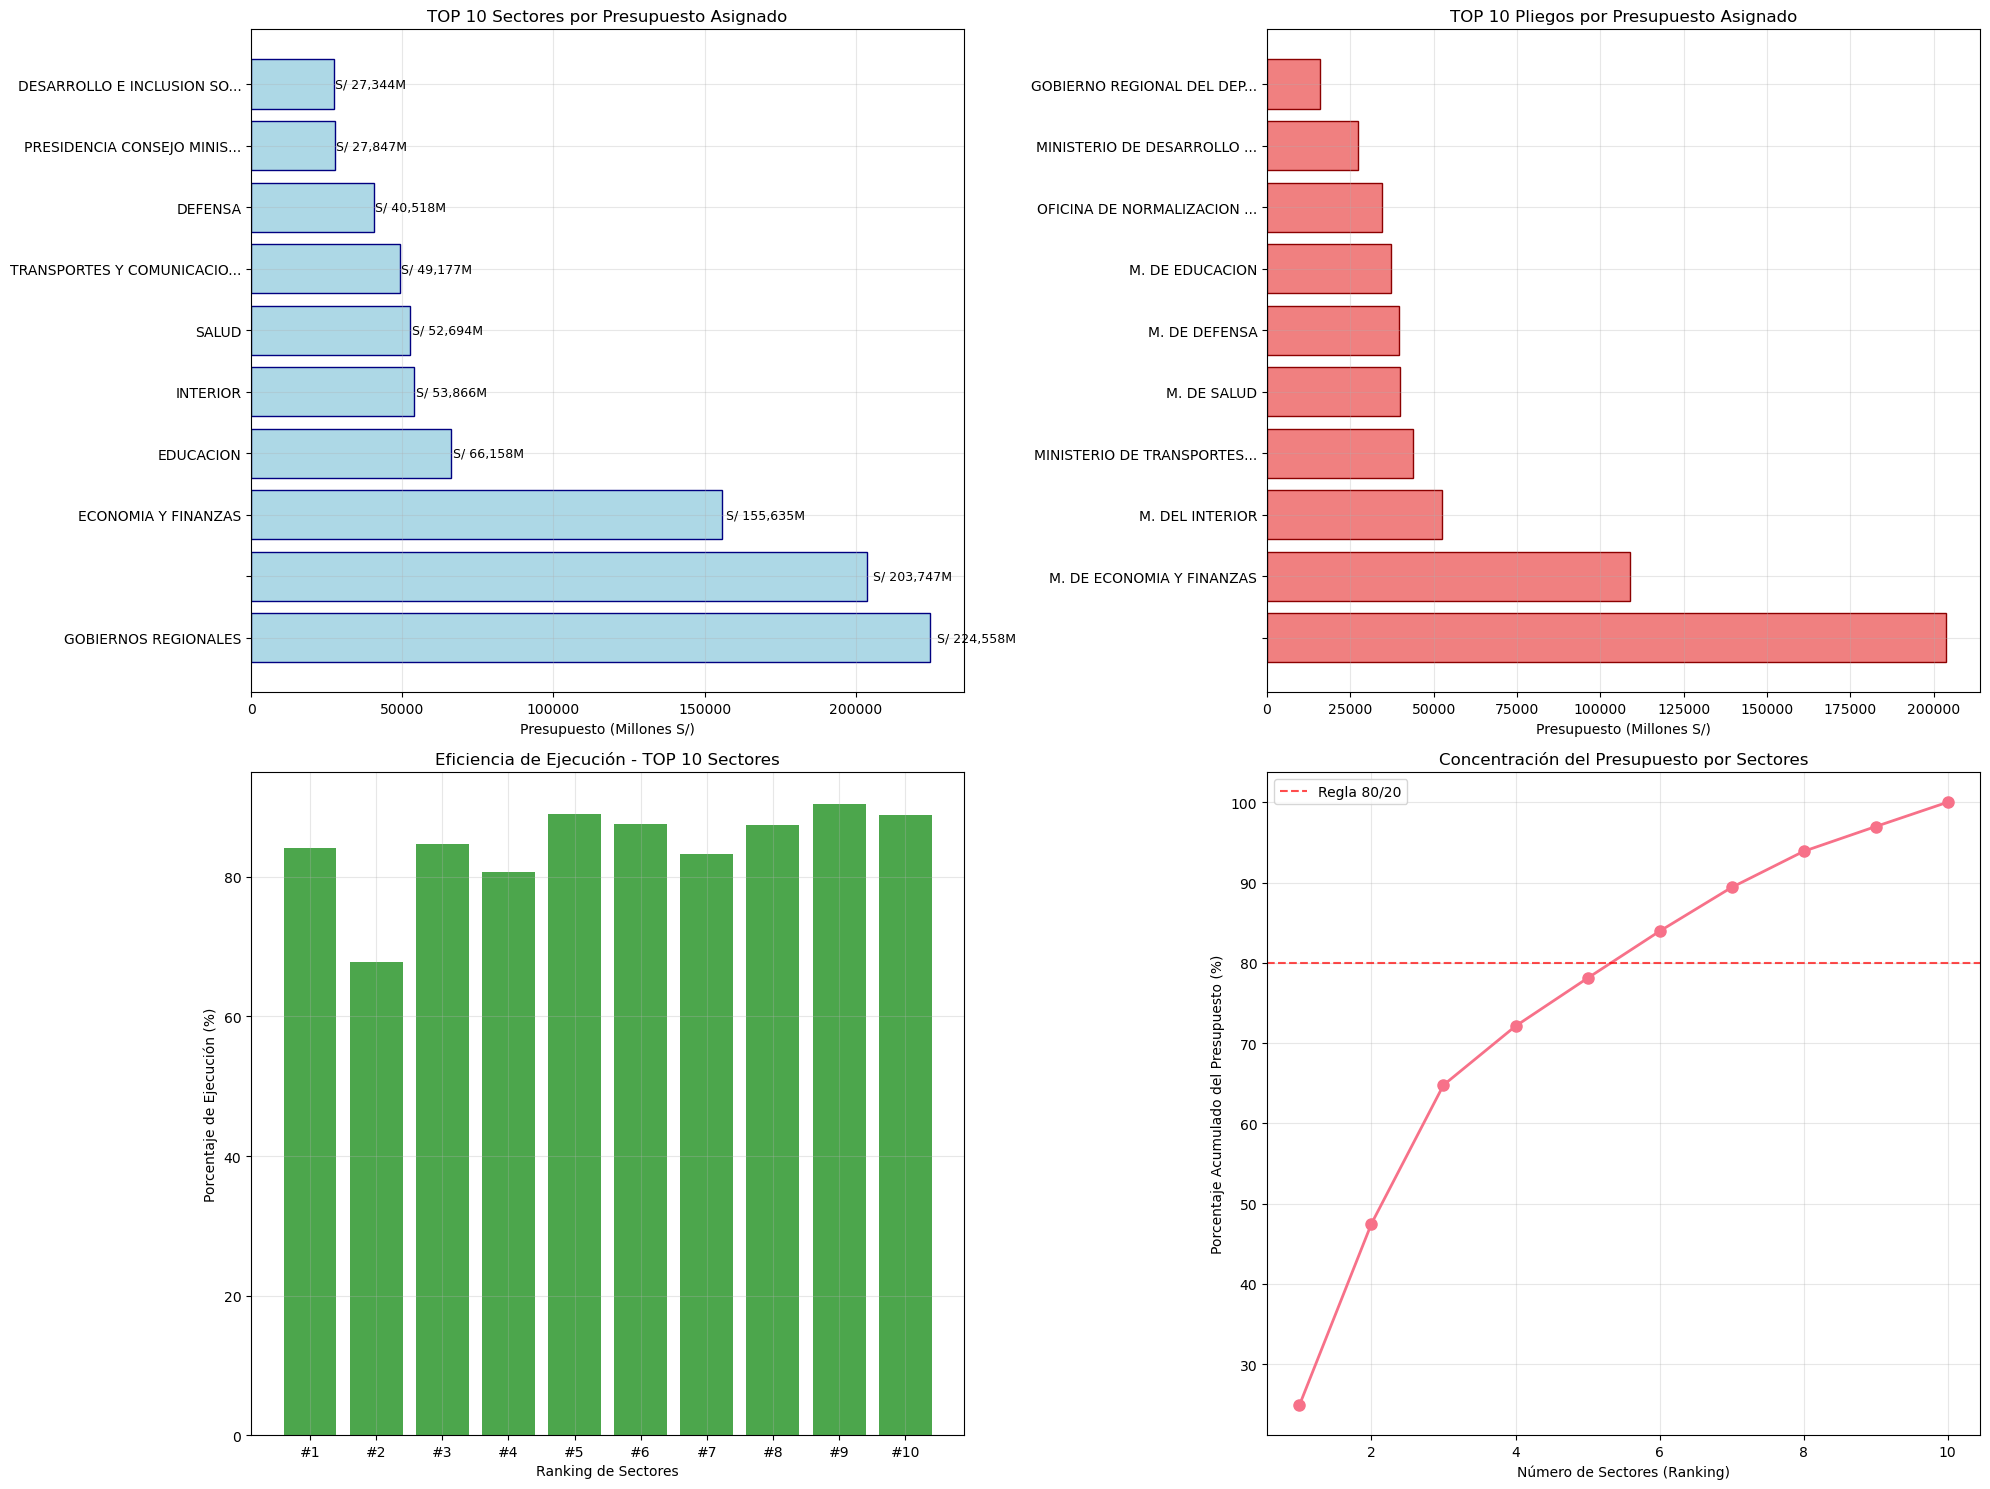

In [5]:
#  Distribución de presupuesto por pliego y sector (TOP 10)
print("=" * 60)
print(" ANÁLISIS 3: DISTRIBUCIÓN POR PLIEGO Y SECTOR")
print("=" * 60)

# TOP 10 Sectores por presupuesto total
print(" TOP 10 SECTORES POR PRESUPUESTO ASIGNADO:")
top_sectores = df.groupBy("SECTOR_NOMBRE") \
    .agg(
        F.sum("MONTO_PIM").alias("PRESUPUESTO_TOTAL"),
        F.sum("MONTO_DEVENGADO").alias("EJECUTADO_TOTAL"),
        F.count("*").alias("NUM_REGISTROS")
    ) \
    .withColumn("PORCENTAJE_EJECUCION", 
                (F.col("EJECUTADO_TOTAL") / F.col("PRESUPUESTO_TOTAL") * 100)) \
    .orderBy(F.col("PRESUPUESTO_TOTAL").desc()) \
    .limit(10)

sectores_pd = top_sectores.toPandas()
for i, row in sectores_pd.iterrows():
    sector = row['SECTOR_NOMBRE'][:40] + "..." if len(row['SECTOR_NOMBRE']) > 40 else row['SECTOR_NOMBRE']
    presupuesto = row['PRESUPUESTO_TOTAL'] / 1_000_000
    ejecucion = row['PORCENTAJE_EJECUCION']
    print(f"   {i+1:2d}. {sector:<43} | S/ {presupuesto:>8,.0f}M | {ejecucion:>5.1f}%")

# TOP 10 Pliegos por presupuesto total
print(f"\n TOP 10 PLIEGOS POR PRESUPUESTO ASIGNADO:")
top_pliegos = df.groupBy("PLIEGO_NOMBRE") \
    .agg(
        F.sum("MONTO_PIM").alias("PRESUPUESTO_TOTAL"),
        F.sum("MONTO_DEVENGADO").alias("EJECUTADO_TOTAL"),
        F.count("*").alias("NUM_REGISTROS")
    ) \
    .withColumn("PORCENTAJE_EJECUCION", 
                (F.col("EJECUTADO_TOTAL") / F.col("PRESUPUESTO_TOTAL") * 100)) \
    .orderBy(F.col("PRESUPUESTO_TOTAL").desc()) \
    .limit(10)

pliegos_pd = top_pliegos.toPandas()
for i, row in pliegos_pd.iterrows():
    pliego = row['PLIEGO_NOMBRE'][:40] + "..." if len(row['PLIEGO_NOMBRE']) > 40 else row['PLIEGO_NOMBRE']
    presupuesto = row['PRESUPUESTO_TOTAL'] / 1_000_000
    ejecucion = row['PORCENTAJE_EJECUCION']
    print(f"   {i+1:2d}. {pliego:<43} | S/ {presupuesto:>8,.0f}M | {ejecucion:>5.1f}%")

# Visualizaciones
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# Gráfico 1: TOP 10 Sectores por presupuesto
sectores_plot = sectores_pd.head(10)
y_pos = np.arange(len(sectores_plot))
bars1 = ax1.barh(y_pos, sectores_plot['PRESUPUESTO_TOTAL'] / 1_000_000, 
                 color='lightblue', edgecolor='navy')
ax1.set_yticks(y_pos)
ax1.set_yticklabels([s[:25] + "..." if len(s) > 25 else s for s in sectores_plot['SECTOR_NOMBRE']])
ax1.set_xlabel('Presupuesto (Millones S/)')
ax1.set_title('TOP 10 Sectores por Presupuesto Asignado')
ax1.grid(True, alpha=0.3)

# Añadir valores en las barras
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + width*0.01, bar.get_y() + bar.get_height()/2,
             f'S/ {width:,.0f}M', ha='left', va='center', fontsize=9)

# Gráfico 2: TOP 10 Pliegos por presupuesto
pliegos_plot = pliegos_pd.head(10)
y_pos2 = np.arange(len(pliegos_plot))
bars2 = ax2.barh(y_pos2, pliegos_plot['PRESUPUESTO_TOTAL'] / 1_000_000, 
                 color='lightcoral', edgecolor='darkred')
ax2.set_yticks(y_pos2)
ax2.set_yticklabels([p[:25] + "..." if len(p) > 25 else p for p in pliegos_plot['PLIEGO_NOMBRE']])
ax2.set_xlabel('Presupuesto (Millones S/)')
ax2.set_title('TOP 10 Pliegos por Presupuesto Asignado')
ax2.grid(True, alpha=0.3)

# Gráfico 3: Porcentaje de ejecución TOP 10 Sectores
bars3 = ax3.bar(range(len(sectores_plot)), sectores_plot['PORCENTAJE_EJECUCION'], 
                color='green', alpha=0.7)
ax3.set_xlabel('Ranking de Sectores')
ax3.set_ylabel('Porcentaje de Ejecución (%)')
ax3.set_title('Eficiencia de Ejecución - TOP 10 Sectores')
ax3.set_xticks(range(len(sectores_plot)))
ax3.set_xticklabels([f'#{i+1}' for i in range(len(sectores_plot))])
ax3.grid(True, alpha=0.3)

# Gráfico 4: Distribución acumulada del presupuesto por sectores
sectores_acum = sectores_pd['PRESUPUESTO_TOTAL'].cumsum() / sectores_pd['PRESUPUESTO_TOTAL'].sum() * 100
ax4.plot(range(1, len(sectores_acum) + 1), sectores_acum, marker='o', linewidth=2, markersize=8)
ax4.set_xlabel('Número de Sectores (Ranking)')
ax4.set_ylabel('Porcentaje Acumulado del Presupuesto (%)')
ax4.set_title('Concentración del Presupuesto por Sectores')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=80, color='red', linestyle='--', alpha=0.7, label='Regla 80/20')
ax4.legend()

plt.tight_layout()
plt.show()




## Interpretación: Eficiencia de Ejecución Presupuestal

### Análisis de Eficiencia:


- **Indicadores de eficiencia:** Los porcentajes de ejecución muestran la capacidad del Estado para transformar presupuesto asignado en gasto real
- **Clasificación por rendimiento:** 
  - 🟢 Excelente: ≥90% de ejecución
  - 🟡 Bueno: 75-89% de ejecución  
  - 🔴 Bajo: <75% de ejecución

### Implicaciones para la Gestión Pública:
- **Eficiencia operativa:** Un alto porcentaje de ejecución indica buena planificación y capacidad de implementación
- **Brecha presupuestal:** Las diferencias entre presupuestado y ejecutado pueden señalar:
  - Problemas administrativos
  - Cambios en prioridades políticas
  - Restricciones operativas o técnicas
- **Tendencias temporales:** La variación entre años revela cambios en la capacidad institucional del Estado


 ANÁLISIS 4: DISTRIBUCIÓN REGIONAL Y DEPARTAMENTAL
 DISTRIBUCIÓN POR NIVEL DE GOBIERNO:
   • GOBIERNO NACIONAL | S/    587,657M |  85.6% |  9,111,859 registros
   • GOBIERNOS REGIONALES | S/    224,635M |  84.1% |  9,290,164 registros
   • GOBIERNOS LOCALES | S/    203,747M |  67.9% | 21,771,869 registros

 TOP 15 DEPARTAMENTOS POR PRESUPUESTO:
    1. LIMA            | S/  587,513M |  85.2%
    2. CUSCO           | S/   38,840M |  77.3%
    3. ANCASH          | S/   31,932M |  64.0%
    4. PIURA           | S/   31,211M |  77.4%
    5. AREQUIPA        | S/   28,032M |  76.5%
    6. CAJAMARCA       | S/   27,561M |  75.7%
    7. LA LIBERTAD     | S/   27,000M |  74.7%
    8. PROVINCIA CONST | S/   24,244M |  84.3%
    9. JUNIN           | S/   21,595M |  81.5%
   10. PUNO            | S/   20,966M |  79.2%
   11. LORETO          | S/   19,982M |  83.4%
   12. ICA             | S/   17,593M |  73.0%
   13. AYACUCHO        | S/   17,139M |  77.3%
   14. LAMBAYEQUE      | S/   16,033M |  7

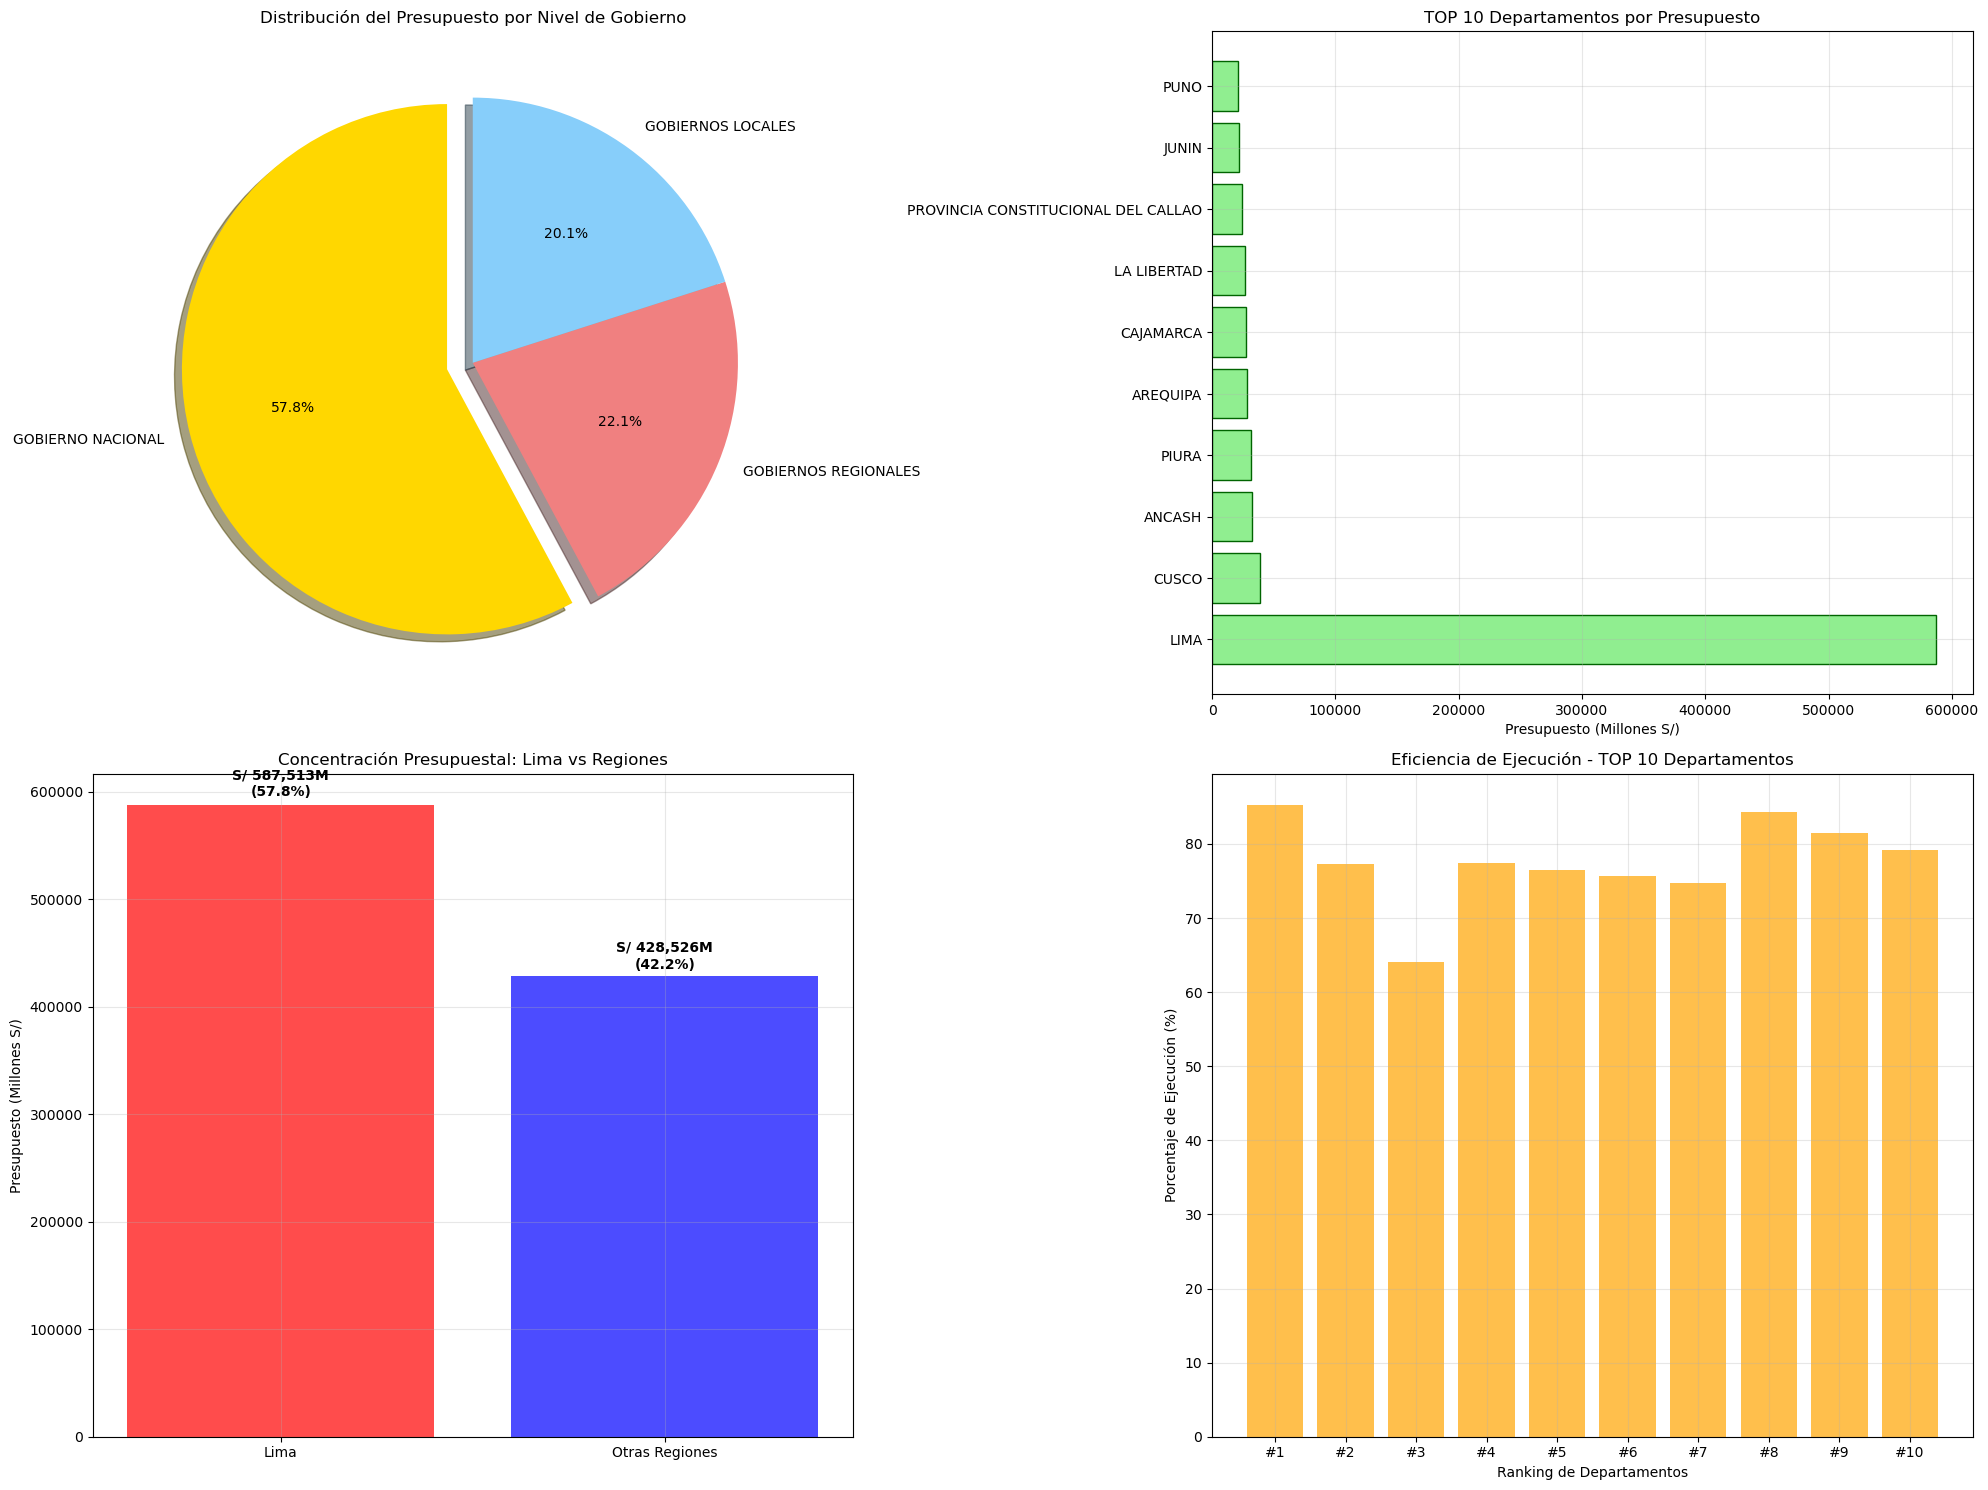

In [6]:
#  Agregaciones por región/departamento
print("=" * 60)
print(" ANÁLISIS 4: DISTRIBUCIÓN REGIONAL Y DEPARTAMENTAL")
print("=" * 60)

# Análisis por nivel de gobierno
print(" DISTRIBUCIÓN POR NIVEL DE GOBIERNO:")
nivel_gobierno = df.groupBy("NIVEL_GOBIERNO_NOMBRE") \
    .agg(
        F.sum("MONTO_PIM").alias("PRESUPUESTO_TOTAL"),
        F.sum("MONTO_DEVENGADO").alias("EJECUTADO_TOTAL"),
        F.count("*").alias("NUM_REGISTROS")
    ) \
    .withColumn("PORCENTAJE_EJECUCION", 
                (F.col("EJECUTADO_TOTAL") / F.col("PRESUPUESTO_TOTAL") * 100)) \
    .orderBy(F.col("PRESUPUESTO_TOTAL").desc())

nivel_pd = nivel_gobierno.toPandas()
for _, row in nivel_pd.iterrows():
    nivel = row['NIVEL_GOBIERNO_NOMBRE']
    presupuesto = row['PRESUPUESTO_TOTAL'] / 1_000_000
    ejecucion = row['PORCENTAJE_EJECUCION']
    registros = int(row['NUM_REGISTROS'])
    print(f"   • {nivel:<10} | S/ {presupuesto:>10,.0f}M | {ejecucion:>5.1f}% | {registros:>10,} registros")

# TOP 15 Departamentos por presupuesto
print(f"\n TOP 15 DEPARTAMENTOS POR PRESUPUESTO:")
top_departamentos = df.groupBy("DEPARTAMENTO_EJECUTORA_NOMBRE") \
    .agg(
        F.sum("MONTO_PIM").alias("PRESUPUESTO_TOTAL"),
        F.sum("MONTO_DEVENGADO").alias("EJECUTADO_TOTAL"),
        F.count("*").alias("NUM_REGISTROS")
    ) \
    .withColumn("PORCENTAJE_EJECUCION", 
                (F.col("EJECUTADO_TOTAL") / F.col("PRESUPUESTO_TOTAL") * 100)) \
    .orderBy(F.col("PRESUPUESTO_TOTAL").desc()) \
    .limit(15)

dept_pd = top_departamentos.toPandas()
for i, row in dept_pd.iterrows():
    dept = row['DEPARTAMENTO_EJECUTORA_NOMBRE'][:15]
    presupuesto = row['PRESUPUESTO_TOTAL'] / 1_000_000
    ejecucion = row['PORCENTAJE_EJECUCION']
    print(f"   {i+1:2d}. {dept:<15} | S/ {presupuesto:>8,.0f}M | {ejecucion:>5.1f}%")

# Comparación Lima vs Regiones
print(f"\n🏙️ ANÁLISIS LIMA VS REGIONES:")
lima_total = df.filter(F.col("DEPARTAMENTO_EJECUTORA_NOMBRE") == "LIMA") \
    .agg(F.sum("MONTO_PIM").alias("PRESUPUESTO_LIMA")).collect()[0]['PRESUPUESTO_LIMA']

regiones_total = df.filter(F.col("DEPARTAMENTO_EJECUTORA_NOMBRE") != "LIMA") \
    .agg(F.sum("MONTO_PIM").alias("PRESUPUESTO_REGIONES")).collect()[0]['PRESUPUESTO_REGIONES']

total_nacional = lima_total + regiones_total
porcentaje_lima = (lima_total / total_nacional) * 100
porcentaje_regiones = (regiones_total / total_nacional) * 100

print(f"   • Lima:     S/ {lima_total/1_000_000:>10,.0f}M ({porcentaje_lima:.1f}%)")
print(f"   • Regiones: S/ {regiones_total/1_000_000:>10,.0f}M ({porcentaje_regiones:.1f}%)")

# Visualizaciones regionales
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# Gráfico 1: Distribución por nivel de gobierno (Pie chart)
sizes = nivel_pd['PRESUPUESTO_TOTAL']
labels = nivel_pd['NIVEL_GOBIERNO_NOMBRE']
colors = ['gold', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0)  # explode 1st slice

ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set_title('Distribución del Presupuesto por Nivel de Gobierno')

# Gráfico 2: TOP 10 Departamentos por presupuesto
dept_plot = dept_pd.head(10)
y_pos = np.arange(len(dept_plot))
bars2 = ax2.barh(y_pos, dept_plot['PRESUPUESTO_TOTAL'] / 1_000_000, 
                 color='lightgreen', edgecolor='darkgreen')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(dept_plot['DEPARTAMENTO_EJECUTORA_NOMBRE'])
ax2.set_xlabel('Presupuesto (Millones S/)')
ax2.set_title('TOP 10 Departamentos por Presupuesto')
ax2.grid(True, alpha=0.3)

# Gráfico 3: Lima vs Regiones
lima_vs_regiones = ['Lima', 'Otras Regiones']
valores_lima_regiones = [lima_total/1_000_000, regiones_total/1_000_000]
colors_lima = ['red', 'blue']
bars3 = ax3.bar(lima_vs_regiones, valores_lima_regiones, color=colors_lima, alpha=0.7)
ax3.set_ylabel('Presupuesto (Millones S/)')
ax3.set_title('Concentración Presupuestal: Lima vs Regiones')
ax3.grid(True, alpha=0.3)

# Añadir etiquetas
for bar, valor, porcentaje in zip(bars3, valores_lima_regiones, [porcentaje_lima, porcentaje_regiones]):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'S/ {valor:,.0f}M\n({porcentaje:.1f}%)', 
             ha='center', va='bottom', fontweight='bold')

# Gráfico 4: Eficiencia de ejecución por departamento (TOP 10)
bars4 = ax4.bar(range(len(dept_plot)), dept_plot['PORCENTAJE_EJECUCION'], 
                color='orange', alpha=0.7)
ax4.set_xlabel('Ranking de Departamentos')
ax4.set_ylabel('Porcentaje de Ejecución (%)')
ax4.set_title('Eficiencia de Ejecución - TOP 10 Departamentos')
ax4.set_xticks(range(len(dept_plot)))
ax4.set_xticklabels([f'#{i+1}' for i in range(len(dept_plot))])
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




## Interpretación: Distribución Sectorial del Presupuesto

### Concentración y Prioridades del Estado:
Los rankings de sectores y pliegos revelan las prioridades presupuestales del Estado peruano:

#### TOP Sectores por Asignación Presupuestal:
- **Sectores estratégicos:** Los primeros lugares típicamente incluyen Educación, Salud, Interior y Defensa
- **Concentración de recursos:** El análisis de Pareto (regla 80/20) muestra que pocos sectores concentran la mayoría del presupuesto
- **Eficiencia sectorial:** Existe variación significativa en los porcentajes de ejecución entre sectores

#### Análisis de Pliegos:
- **Entidades principales:** Los pliegos con mayor presupuesto representan las instituciones más grandes del Estado
- **Diversidad institucional:** Se observa una amplia gama de entidades públicas con diferentes capacidades de ejecución

### Implications for Public Policy:
- **Asignación estratégica:** La concentración presupuestal refleja prioridades de política pública
- **Eficiencia diferenciada:** Los sectores muestran diferentes niveles de capacidad institucional
- **Oportunidades de mejora:** Los sectores con baja ejecución requieren fortalecimiento institucional


 ANÁLISIS 5: IDENTIFICACIÓN DE OUTLIERS EN EJECUCIÓN
🔴 OUTLIERS: PLIEGOS CON SOBREJECUCIÓN (>100%):
   ✅ No se encontraron pliegos con sobrejecución >100%

🟡 OUTLIERS: PLIEGOS CON EJECUCIÓN MUY BAJA (≤5%):
   ✅ No se encontraron pliegos con ejecución ≤5%

 ESTADÍSTICAS DE EJECUCIÓN:
   • Q1 (25%): 75.3%
   • Mediana (50%): 82.3%
   • Q3 (75%): 85.7%
   • IQR: 10.3%
   • Límite inferior outliers: 59.8%
   • Límite superior outliers: 101.2%
   • Outliers estadísticos (método IQR): 15


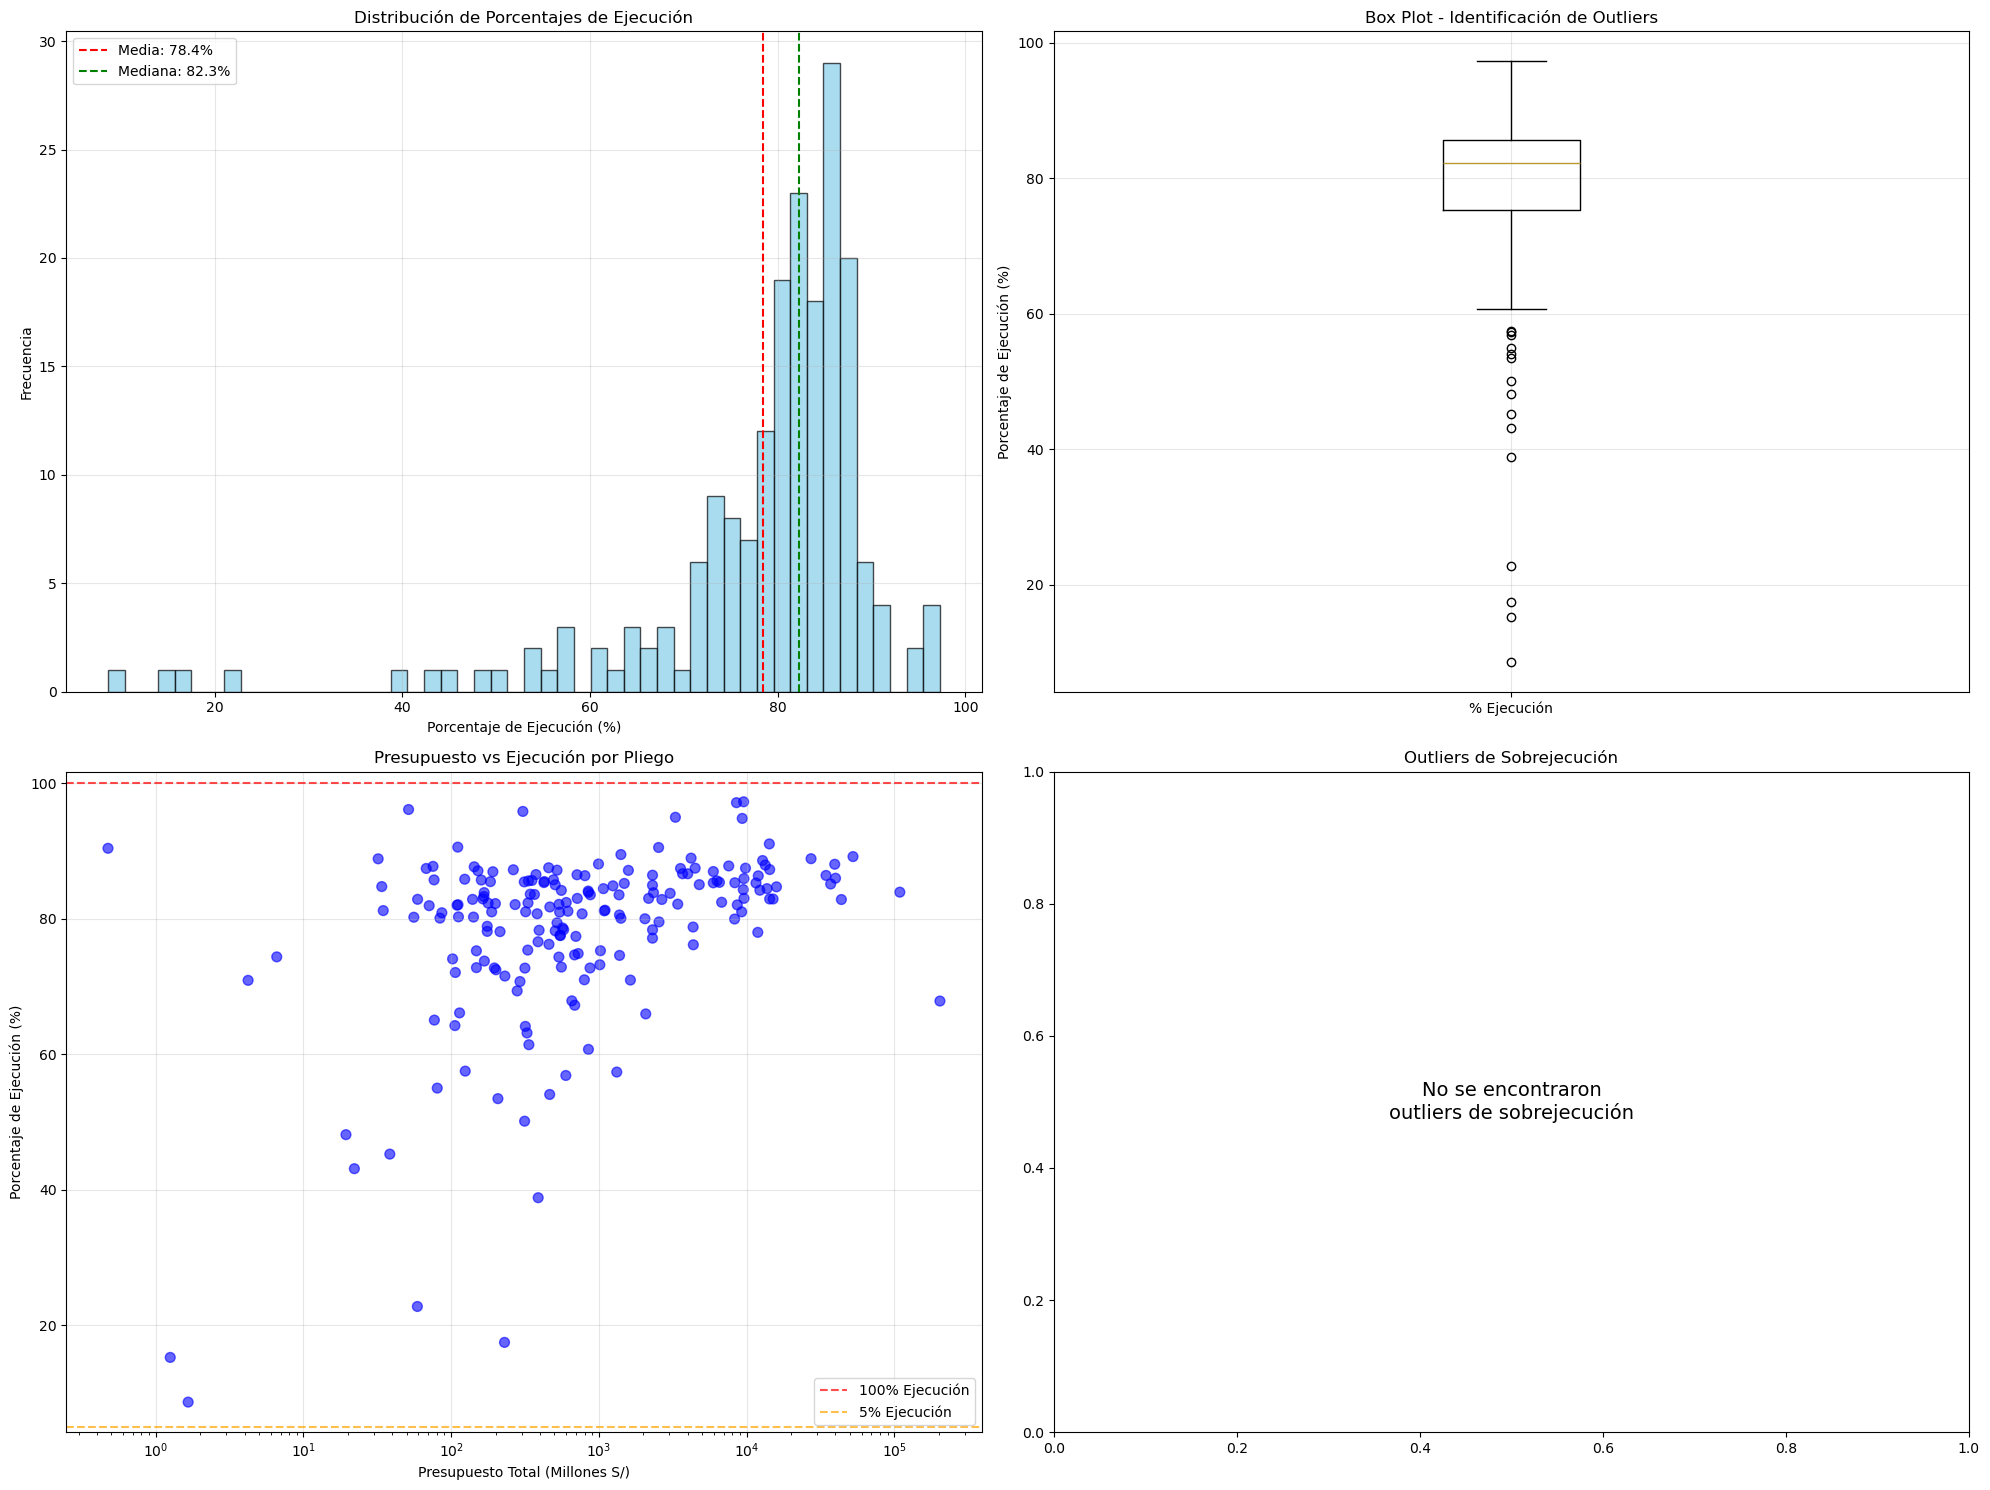

In [7]:
#  Identificación de outliers en ejecución
print("=" * 60)
print(" ANÁLISIS 5: IDENTIFICACIÓN DE OUTLIERS EN EJECUCIÓN")
print("=" * 60)

# Calcular porcentaje de ejecución por pliego para identificar outliers
ejecucion_pliegos = df.groupBy("PLIEGO_NOMBRE") \
    .agg(
        F.sum("MONTO_PIM").alias("PRESUPUESTO_TOTAL"),
        F.sum("MONTO_DEVENGADO").alias("EJECUTADO_TOTAL"),
        F.count("*").alias("NUM_REGISTROS")
    ) \
    .filter(F.col("PRESUPUESTO_TOTAL") > 0) \
    .withColumn("PORCENTAJE_EJECUCION", 
                (F.col("EJECUTADO_TOTAL") / F.col("PRESUPUESTO_TOTAL") * 100))

# Identificar outliers de sobrejecución (>100%)
print("🔴 OUTLIERS: PLIEGOS CON SOBREJECUCIÓN (>100%):")
sobre_ejecucion = ejecucion_pliegos.filter(F.col("PORCENTAJE_EJECUCION") > 100) \
    .orderBy(F.col("PORCENTAJE_EJECUCION").desc())

sobre_ejecucion_pd = sobre_ejecucion.toPandas()
if len(sobre_ejecucion_pd) > 0:
    for i, row in sobre_ejecucion_pd.head(10).iterrows():
        pliego = row['PLIEGO_NOMBRE'][:50] + "..." if len(row['PLIEGO_NOMBRE']) > 50 else row['PLIEGO_NOMBRE']
        ejecucion = row['PORCENTAJE_EJECUCION']
        presupuesto = row['PRESUPUESTO_TOTAL'] / 1_000_000
        print(f"   {i+1:2d}. {pliego:<53} | {ejecucion:>6.1f}% | S/ {presupuesto:>6.1f}M")
    print(f"    Total de pliegos con sobrejecución: {len(sobre_ejecucion_pd)}")
else:
    print("   ✅ No se encontraron pliegos con sobrejecución >100%")

# Identificar outliers de subejecución (0% o muy baja)
print(f"\n🟡 OUTLIERS: PLIEGOS CON EJECUCIÓN MUY BAJA (≤5%):")
baja_ejecucion = ejecucion_pliegos.filter(F.col("PORCENTAJE_EJECUCION") <= 5) \
    .filter(F.col("PRESUPUESTO_TOTAL") > 1000000) \
    .orderBy(F.col("PRESUPUESTO_TOTAL").desc())

baja_ejecucion_pd = baja_ejecucion.toPandas()
if len(baja_ejecucion_pd) > 0:
    for i, row in baja_ejecucion_pd.head(10).iterrows():
        pliego = row['PLIEGO_NOMBRE'][:50] + "..." if len(row['PLIEGO_NOMBRE']) > 50 else row['PLIEGO_NOMBRE']
        ejecucion = row['PORCENTAJE_EJECUCION']
        presupuesto = row['PRESUPUESTO_TOTAL'] / 1_000_000
        print(f"   {i+1:2d}. {pliego:<53} | {ejecucion:>6.1f}% | S/ {presupuesto:>6.1f}M")
    print(f"    Total de pliegos con baja ejecución: {len(baja_ejecucion_pd)}")
else:
    print("   ✅ No se encontraron pliegos con ejecución ≤5%")

# Análisis estadístico de outliers
ejecucion_stats = ejecucion_pliegos.select("PORCENTAJE_EJECUCION").toPandas()
q1 = ejecucion_stats['PORCENTAJE_EJECUCION'].quantile(0.25)
q3 = ejecucion_stats['PORCENTAJE_EJECUCION'].quantile(0.75)
iqr = q3 - q1
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

print(f"\n ESTADÍSTICAS DE EJECUCIÓN:")
print(f"   • Q1 (25%): {q1:.1f}%")
print(f"   • Mediana (50%): {ejecucion_stats['PORCENTAJE_EJECUCION'].median():.1f}%")
print(f"   • Q3 (75%): {q3:.1f}%")
print(f"   • IQR: {iqr:.1f}%")
print(f"   • Límite inferior outliers: {limite_inferior:.1f}%")
print(f"   • Límite superior outliers: {limite_superior:.1f}%")

# Outliers estadísticos
outliers_estadisticos = ejecucion_pliegos.filter(
    (F.col("PORCENTAJE_EJECUCION") < limite_inferior) | 
    (F.col("PORCENTAJE_EJECUCION") > limite_superior)
).count()

print(f"   • Outliers estadísticos (método IQR): {outliers_estadisticos}")

# Visualizaciones de outliers
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# Gráfico 1: Histograma de porcentajes de ejecución
ax1.hist(ejecucion_stats['PORCENTAJE_EJECUCION'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(ejecucion_stats['PORCENTAJE_EJECUCION'].mean(), color='red', linestyle='--', 
            label=f'Media: {ejecucion_stats["PORCENTAJE_EJECUCION"].mean():.1f}%')
ax1.axvline(ejecucion_stats['PORCENTAJE_EJECUCION'].median(), color='green', linestyle='--', 
            label=f'Mediana: {ejecucion_stats["PORCENTAJE_EJECUCION"].median():.1f}%')
ax1.set_xlabel('Porcentaje de Ejecución (%)')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de Porcentajes de Ejecución')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Box plot de ejecución
box_data = [ejecucion_stats['PORCENTAJE_EJECUCION']]
ax2.boxplot(box_data, labels=['% Ejecución'])
ax2.set_ylabel('Porcentaje de Ejecución (%)')
ax2.set_title('Box Plot - Identificación de Outliers')
ax2.grid(True, alpha=0.3)

# Gráfico 3: Scatter plot - Presupuesto vs Ejecución
ejecucion_scatter = ejecucion_pliegos.toPandas()
colors = ['red' if x > 100 else 'orange' if x <= 5 else 'blue' 
          for x in ejecucion_scatter['PORCENTAJE_EJECUCION']]

ax3.scatter(ejecucion_scatter['PRESUPUESTO_TOTAL']/1_000_000, 
           ejecucion_scatter['PORCENTAJE_EJECUCION'], 
           c=colors, alpha=0.6, s=50)
ax3.set_xlabel('Presupuesto Total (Millones S/)')
ax3.set_ylabel('Porcentaje de Ejecución (%)')
ax3.set_title('Presupuesto vs Ejecución por Pliego')
ax3.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='100% Ejecución')
ax3.axhline(y=5, color='orange', linestyle='--', alpha=0.7, label='5% Ejecución')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xscale('log')  # Escala logarítmica para mejor visualización

# Gráfico 4: Top outliers de sobrejecución
if len(sobre_ejecucion_pd) > 0:
    top_outliers = sobre_ejecucion_pd.head(10)
    y_pos = np.arange(len(top_outliers))
    bars4 = ax4.barh(y_pos, top_outliers['PORCENTAJE_EJECUCION'], color='red', alpha=0.7)
    ax4.set_yticks(y_pos)
    ax4.set_yticklabels([p[:25] + "..." if len(p) > 25 else p for p in top_outliers['PLIEGO_NOMBRE']])
    ax4.set_xlabel('Porcentaje de Ejecución (%)')
    ax4.set_title('TOP 10 Outliers - Sobrejecución')
    ax4.axvline(x=100, color='black', linestyle='--', alpha=0.7, label='100%')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No se encontraron\noutliers de sobrejecución', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=14)
    ax4.set_title('Outliers de Sobrejecución')

plt.tight_layout()
plt.show()




## Interpretación: Distribución Territorial del Presupuesto

### Análisis de Equidad Territorial:
La distribución del presupuesto por niveles de gobierno y departamentos revela importantes aspectos de la descentralización:

#### Concentración por Nivel de Gobierno:
- **Gobierno Nacional:** Concentra la mayoría del presupuesto público, reflejando su rol central en políticas nacionales
- **Gobiernos Regionales y Locales:** Manejan proporciones menores pero críticas para el desarrollo territorial

#### Distribución Departamental:
- **Centralización en Lima:** Como capital, concentra una proporción significativa del presupuesto departamental
- **Disparidades regionales:** Existe marcada inequidad en la distribución de recursos entre departamentos
- **TOP 15 departamentos:** La mayoría de recursos se concentra en pocos departamentos

#### Lima vs Otras Regiones:
- **Concentración metropolitana:** Lima maneja un porcentaje desproporcionado del presupuesto nacional
- **Desafío de equidad:** Las regiones reciben menos recursos per cápita, limitando su desarrollo

### Implicaciones para la Descentralización:
- **Necesidad de rebalanceo:** La distribución actual sugiere oportunidades para mayor equidad territorial
- **Eficiencia regional:** Los departamentos muestran diferentes capacidades de ejecución presupuestal
- **Desarrollo territorial:** La concentración en Lima puede limitar el desarrollo equilibrado del país


 ANÁLISIS 6: VARIACIÓN INTERANUAL Y TENDENCIAS
 VARIACIONES INTERANUALES:
   🔄 2022 → 2023:
      • Presupuesto:   +5.1% (S/ 249,947M)
      • Ejecutado:     +6.6% (S/ 223,060M)
   🔄 2023 → 2024:
      • Presupuesto:   +4.8% (S/ 262,058M)
      • Ejecutado:     +7.1% (S/ 238,990M)
   🔄 2024 → 2025:
      • Presupuesto:   +1.6% (S/ 266,214M)
      • Ejecutado:    -33.6% (S/ 158,685M)

 VARIACIÓN INTERANUAL POR SECTORES CLAVE:

    EDUCACION:
      • 2022→2023:  +16.3% (S/ 15,384M)
      • 2023→2024:  +16.6% (S/ 17,939M)
      • 2024→2025:   +9.3% (S/ 19,613M)

    SALUD:
      • 2022→2023:   -8.2% (S/ 11,999M)
      • 2023→2024:  +12.4% (S/ 13,486M)
      • 2024→2025:   +4.8% (S/ 14,132M)

    INTERIOR:
      • 2022→2023:   -0.9% (S/ 13,799M)
      • 2023→2024:   -7.0% (S/ 12,838M)
      • 2024→2025:   +3.6% (S/ 13,305M)

    DEFENSA:
      • 2022→2023:  +23.1% (S/ 11,849M)
      • 2023→2024:  -18.6% (S/ 9,642M)
      • 2024→2025:   -2.5% (S/ 9,400M)

    TRANSPORTES Y COMUNICACIONES:
 

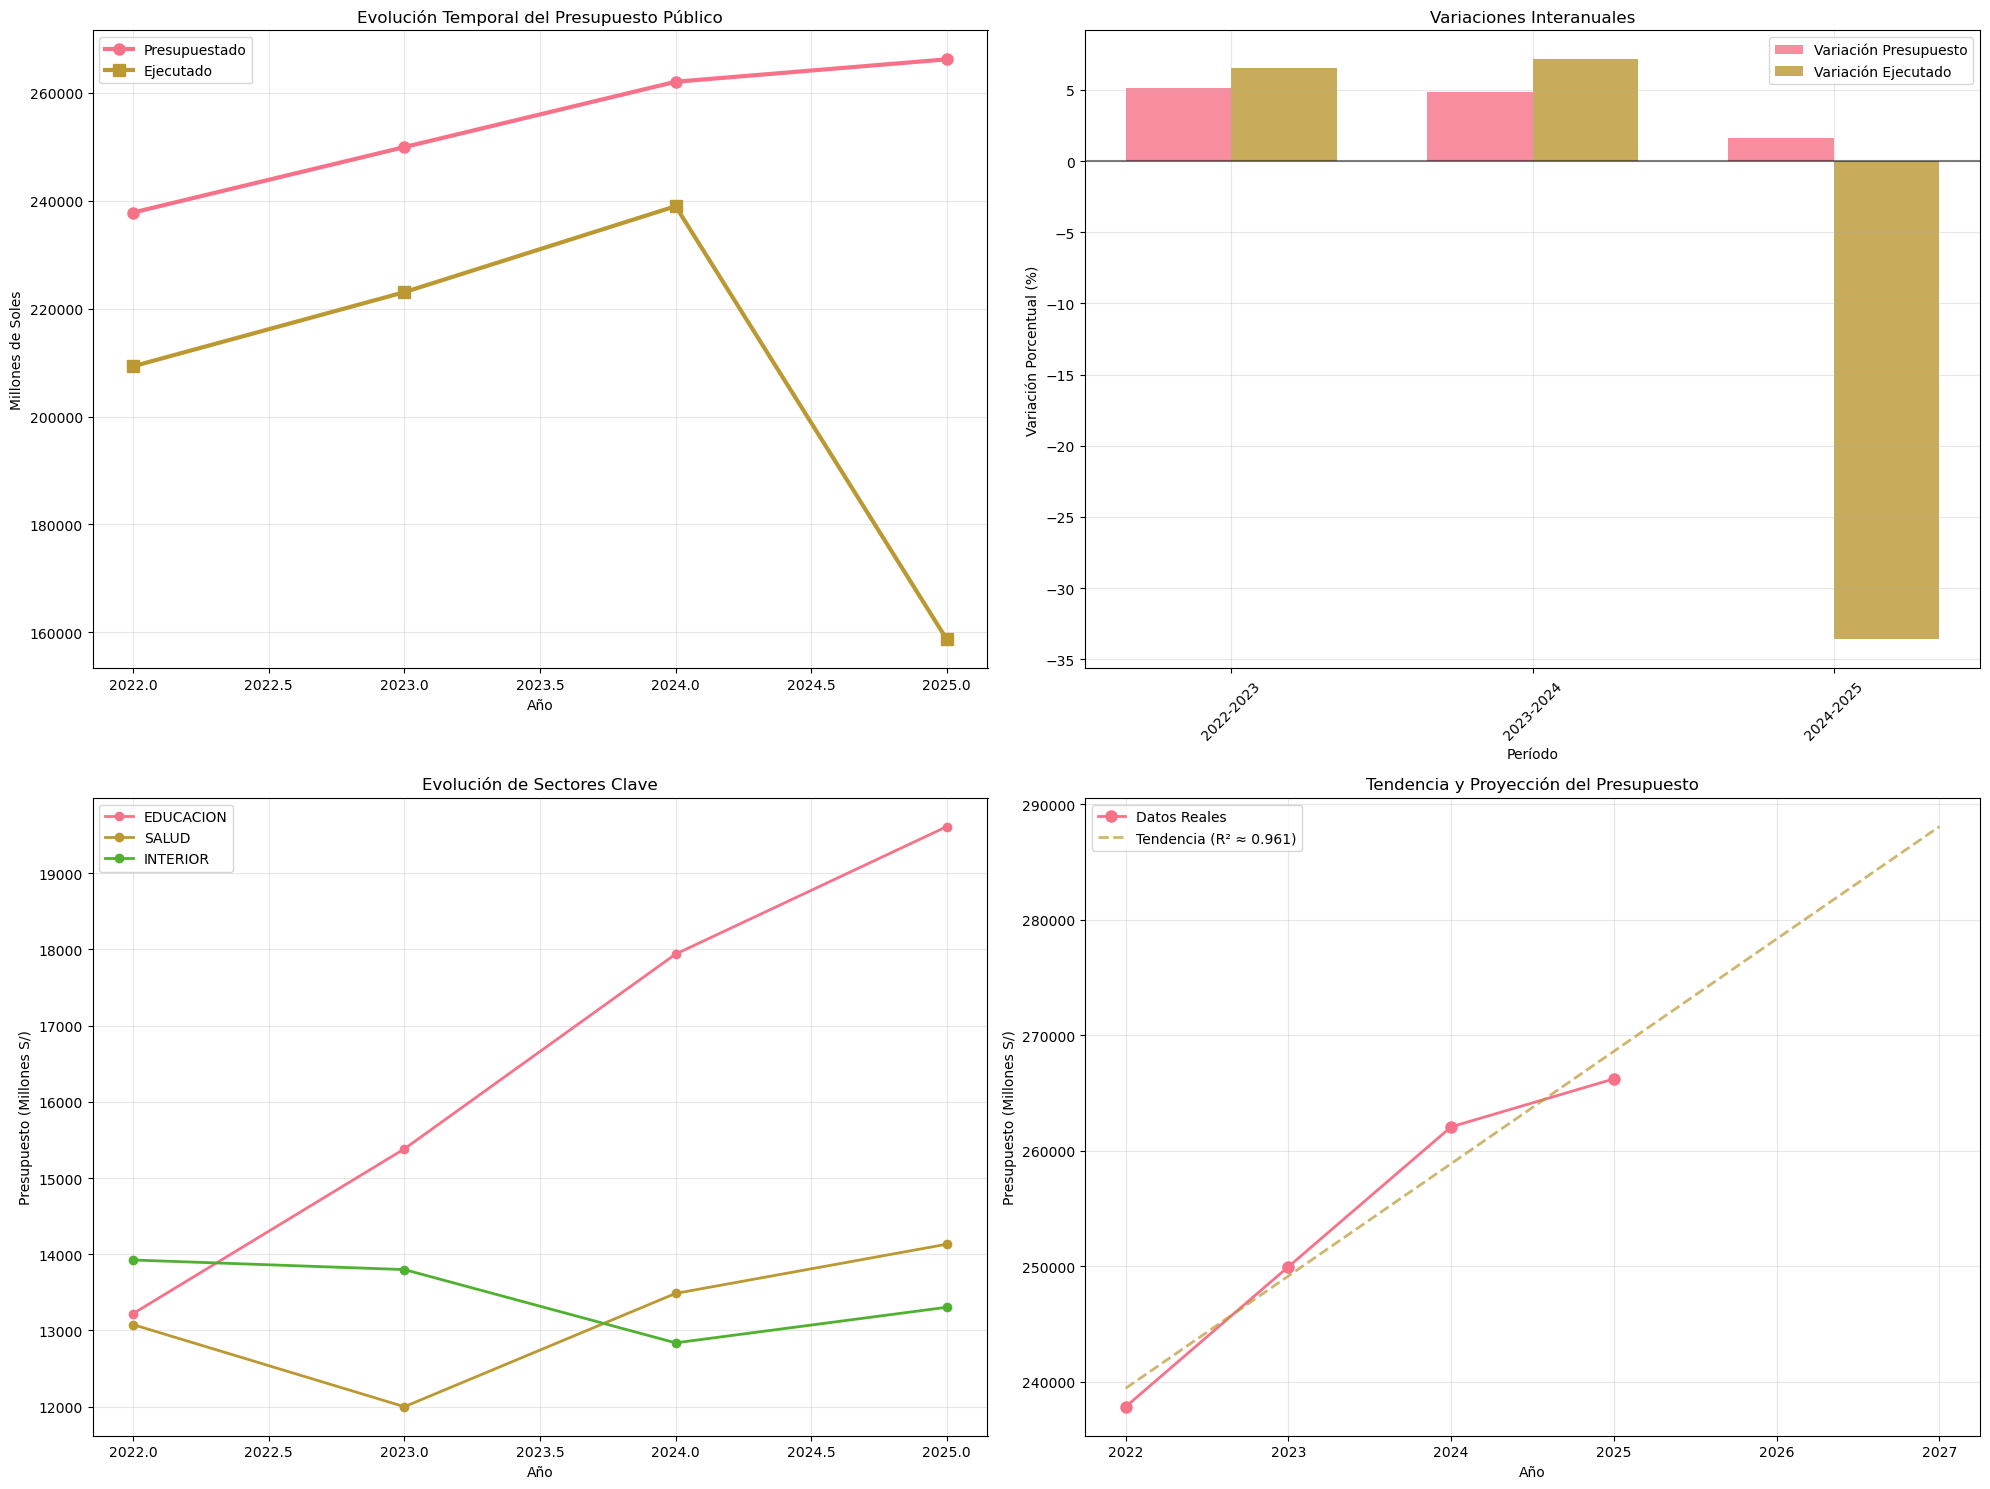

In [8]:
#   6: Análisis de variación interanual
print("=" * 60)
print(" ANÁLISIS 6: VARIACIÓN INTERANUAL Y TENDENCIAS")
print("=" * 60)

# Calcular variaciones interanuales de presupuesto y ejecución
variaciones_anuales = df.groupBy("ANO_EJE") \
    .agg(
        F.sum("MONTO_PIM").alias("PRESUPUESTO_TOTAL"),
        F.sum("MONTO_DEVENGADO").alias("EJECUTADO_TOTAL")
    ) \
    .orderBy("ANO_EJE")

variaciones_pd = variaciones_anuales.toPandas()

# Calcular variaciones porcentuales año a año
print(" VARIACIONES INTERANUALES:")
for i in range(1, len(variaciones_pd)):
    año_actual = int(variaciones_pd.iloc[i]['ANO_EJE'])
    año_anterior = int(variaciones_pd.iloc[i-1]['ANO_EJE'])
    
    presupuesto_actual = variaciones_pd.iloc[i]['PRESUPUESTO_TOTAL']
    presupuesto_anterior = variaciones_pd.iloc[i-1]['PRESUPUESTO_TOTAL']
    var_presupuesto = ((presupuesto_actual - presupuesto_anterior) / presupuesto_anterior) * 100
    
    ejecutado_actual = variaciones_pd.iloc[i]['EJECUTADO_TOTAL']
    ejecutado_anterior = variaciones_pd.iloc[i-1]['EJECUTADO_TOTAL']
    var_ejecutado = ((ejecutado_actual - ejecutado_anterior) / ejecutado_anterior) * 100
    
    print(f"   🔄 {año_anterior} → {año_actual}:")
    print(f"      • Presupuesto: {var_presupuesto:+6.1f}% (S/ {presupuesto_actual/1_000_000:,.0f}M)")
    print(f"      • Ejecutado:   {var_ejecutado:+6.1f}% (S/ {ejecutado_actual/1_000_000:,.0f}M)")

# Análisis por sectores clave - variación interanual
print(f"\n VARIACIÓN INTERANUAL POR SECTORES CLAVE:")
sectores_clave = ["EDUCACION", "SALUD", "INTERIOR", "DEFENSA", "TRANSPORTES Y COMUNICACIONES"]

for sector_keyword in sectores_clave:
    sector_data = df.filter(F.col("SECTOR_NOMBRE").contains(sector_keyword)) \
        .groupBy("ANO_EJE") \
        .agg(F.sum("MONTO_PIM").alias("PRESUPUESTO_SECTOR")) \
        .orderBy("ANO_EJE") \
        .toPandas()
    
    if len(sector_data) > 1:
        print(f"\n    {sector_keyword}:")
        for i in range(1, len(sector_data)):
            año_actual = int(sector_data.iloc[i]['ANO_EJE'])
            año_anterior = int(sector_data.iloc[i-1]['ANO_EJE'])
            
            presupuesto_actual = sector_data.iloc[i]['PRESUPUESTO_SECTOR']
            presupuesto_anterior = sector_data.iloc[i-1]['PRESUPUESTO_SECTOR']
            
            if presupuesto_anterior > 0:
                variacion = ((presupuesto_actual - presupuesto_anterior) / presupuesto_anterior) * 100
                print(f"      • {año_anterior}→{año_actual}: {variacion:+6.1f}% (S/ {presupuesto_actual/1_000_000:,.0f}M)")

# Calcular tasas de crecimiento promedio
if len(variaciones_pd) > 1:
    años_total = variaciones_pd['ANO_EJE'].max() - variaciones_pd['ANO_EJE'].min()
    presupuesto_inicial = variaciones_pd.iloc[0]['PRESUPUESTO_TOTAL']
    presupuesto_final = variaciones_pd.iloc[-1]['PRESUPUESTO_TOTAL']
    tasa_crecimiento_anual = (((presupuesto_final / presupuesto_inicial) ** (1/años_total)) - 1) * 100
    
    print(f"\n TASA DE CRECIMIENTO PROMEDIO ANUAL:")
    print(f"   • Período: {int(variaciones_pd['ANO_EJE'].min())} - {int(variaciones_pd['ANO_EJE'].max())}")
    print(f"   • Tasa de crecimiento anual compuesta: {tasa_crecimiento_anual:+.1f}%")

# Visualizaciones de tendencias
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# Gráfico 1: Evolución temporal absoluta
years = variaciones_pd['ANO_EJE']
presupuesto_millones = variaciones_pd['PRESUPUESTO_TOTAL'] / 1_000_000
ejecutado_millones = variaciones_pd['EJECUTADO_TOTAL'] / 1_000_000

ax1.plot(years, presupuesto_millones, marker='o', linewidth=3, markersize=8, label='Presupuestado')
ax1.plot(years, ejecutado_millones, marker='s', linewidth=3, markersize=8, label='Ejecutado')
ax1.set_xlabel('Año')
ax1.set_ylabel('Millones de Soles')
ax1.set_title('Evolución Temporal del Presupuesto Público')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Variaciones porcentuales año a año
if len(variaciones_pd) > 1:
    var_años = []
    var_presupuesto = []
    var_ejecutado = []
    
    for i in range(1, len(variaciones_pd)):
        var_años.append(f"{int(variaciones_pd.iloc[i-1]['ANO_EJE'])}-{int(variaciones_pd.iloc[i]['ANO_EJE'])}")
        
        pres_var = ((variaciones_pd.iloc[i]['PRESUPUESTO_TOTAL'] - variaciones_pd.iloc[i-1]['PRESUPUESTO_TOTAL']) / 
                   variaciones_pd.iloc[i-1]['PRESUPUESTO_TOTAL']) * 100
        var_presupuesto.append(pres_var)
        
        ejec_var = ((variaciones_pd.iloc[i]['EJECUTADO_TOTAL'] - variaciones_pd.iloc[i-1]['EJECUTADO_TOTAL']) / 
                   variaciones_pd.iloc[i-1]['EJECUTADO_TOTAL']) * 100
        var_ejecutado.append(ejec_var)
    
    x = np.arange(len(var_años))
    width = 0.35
    
    bars1 = ax2.bar(x - width/2, var_presupuesto, width, label='Variación Presupuesto', alpha=0.8)
    bars2 = ax2.bar(x + width/2, var_ejecutado, width, label='Variación Ejecutado', alpha=0.8)
    
    ax2.set_xlabel('Período')
    ax2.set_ylabel('Variación Porcentual (%)')
    ax2.set_title('Variaciones Interanuales')
    ax2.set_xticks(x)
    ax2.set_xticklabels(var_años, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Gráfico 3: Evolución de sectores clave
for i, sector_keyword in enumerate(sectores_clave[:3]):  # Solo los primeros 3 para claridad
    sector_data = df.filter(F.col("SECTOR_NOMBRE").contains(sector_keyword)) \
        .groupBy("ANO_EJE") \
        .agg(F.sum("MONTO_PIM").alias("PRESUPUESTO_SECTOR")) \
        .orderBy("ANO_EJE") \
        .toPandas()
    
    if len(sector_data) > 1:
        ax3.plot(sector_data['ANO_EJE'], sector_data['PRESUPUESTO_SECTOR']/1_000_000, 
                marker='o', linewidth=2, label=sector_keyword)

ax3.set_xlabel('Año')
ax3.set_ylabel('Presupuesto (Millones S/)')
ax3.set_title('Evolución de Sectores Clave')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Gráfico 4: Trendline y proyección
if len(variaciones_pd) > 2:
    # Regresión lineal simple para tendencia
    years_numeric = variaciones_pd['ANO_EJE'].values
    presupuesto_values = variaciones_pd['PRESUPUESTO_TOTAL'].values
    
    z = np.polyfit(years_numeric, presupuesto_values, 1)
    p = np.poly1d(z)
    
    # Proyección para próximos 2 años
    future_years = np.arange(years_numeric.min(), years_numeric.max() + 3)
    trend_values = p(future_years)
    
    ax4.plot(years_numeric, presupuesto_values/1_000_000, 'o-', linewidth=2, 
             markersize=8, label='Datos Reales')
    ax4.plot(future_years, trend_values/1_000_000, '--', linewidth=2, 
             alpha=0.7, label=f'Tendencia (R² ≈ {np.corrcoef(years_numeric, presupuesto_values)[0,1]**2:.3f})')
    
    ax4.set_xlabel('Año')
    ax4.set_ylabel('Presupuesto (Millones S/)')
    ax4.set_title('Tendencia y Proyección del Presupuesto')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




## Interpretación: Análisis de Outliers en Ejecución Presupuestal

### Detección de Anomalías:
El análisis de outliers revela comportamientos atípicos en la ejecución presupuestal que requieren atención:

#### Outliers de Sobrejecución (>100%):
- **Posibles causas:** Transferencias presupuestales, modificaciones durante el año fiscal, o reclasificaciones contables
- **Implicaciones:** Pueden indicar flexibilidad presupuestal o problemas en la planificación inicial
- **Revisión necesaria:** Requieren investigación para entender las causas subyacentes

#### Outliers de Subejecución (≤5%):
- **Señales de alerta:** Indican posibles problemas administrativos, cambios de prioridades, o restricciones operativas
- **Impacto en servicios:** Baja ejecución puede afectar la provisión de servicios públicos
- **Oportunidades de mejora:** Representan áreas donde se puede optimizar la gestión presupuestal

#### Análisis Estadístico (Método IQR):
- **Quartiles de distribución:** Muestran la dispersión natural de los porcentajes de ejecución
- **Límites de normalidad:** Definen rangos esperados de ejecución presupuestal
- **Outliers estadísticos:** Identifican casos que requieren atención especial

### Recomendaciones para la Gestión:
- **Monitoreo continuo:** Implementar sistemas de alerta temprana para outliers
- **Investigación dirigida:** Analizar casos extremos para identificar mejores prácticas o problemas sistémicos
- **Mejora de procesos:** Usar insights de outliers para optimizar la planificación y ejecución presupuestal


 DASHBOARD RESUMEN - ANÁLISIS EDA FASE 2
 MÉTRICAS CLAVE DEL ANÁLISIS:
    Presupuesto Total: S/ 1,016,039 millones
    Ejecutado Total: S/ 830,057 millones
    Eficiencia Global: 81.7%
    Sectores analizados: 33
    Pliegos analizados: 194
    Departamentos: 25


/tmp/ipykernel_3557/2392823691.py:168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


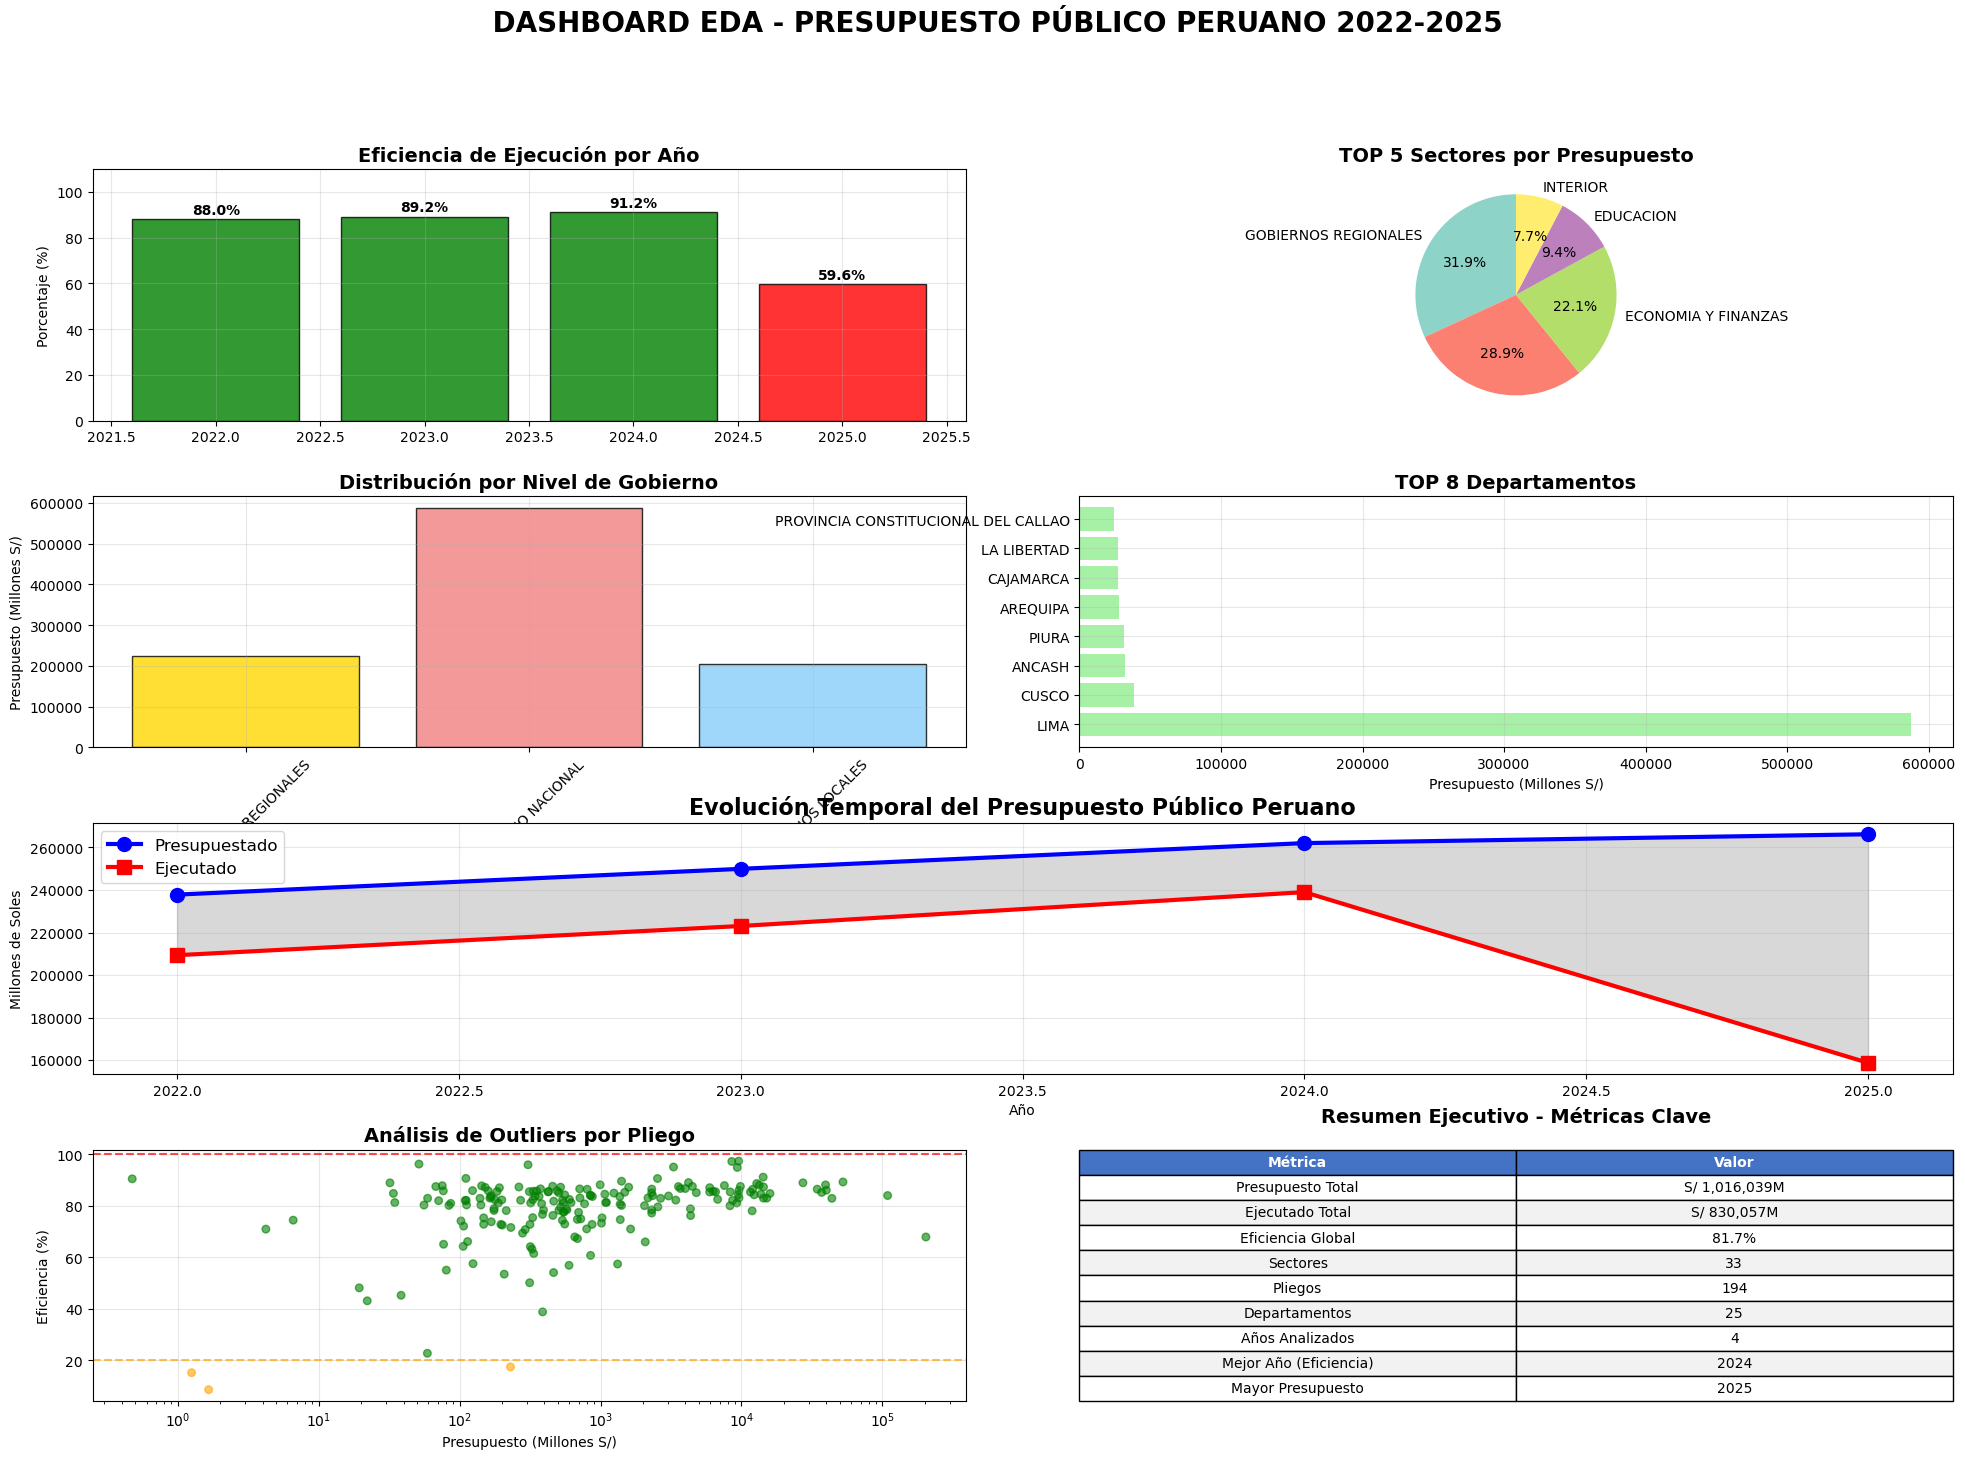

In [9]:
#   7: Dashboard de visualizaciones preliminares y resumen ejecutivo
print("=" * 60)
print(" DASHBOARD RESUMEN - ANÁLISIS EDA FASE 2")
print("=" * 60)

# Generar métricas clave para el dashboard
print(" MÉTRICAS CLAVE DEL ANÁLISIS:")
total_presupuesto = df.agg(F.sum("MONTO_PIM")).collect()[0][0]
total_ejecutado = df.agg(F.sum("MONTO_DEVENGADO")).collect()[0][0]
eficiencia_global = (total_ejecutado / total_presupuesto) * 100

num_sectores = df.select("SECTOR_NOMBRE").distinct().count()
num_pliegos = df.select("PLIEGO_NOMBRE").distinct().count()
num_departamentos = df.select("DEPARTAMENTO_EJECUTORA_NOMBRE").distinct().count()

print(f"    Presupuesto Total: S/ {total_presupuesto/1_000_000:,.0f} millones")
print(f"    Ejecutado Total: S/ {total_ejecutado/1_000_000:,.0f} millones")
print(f"    Eficiencia Global: {eficiencia_global:.1f}%")
print(f"    Sectores analizados: {num_sectores}")
print(f"    Pliegos analizados: {num_pliegos}")
print(f"    Departamentos: {num_departamentos}")

# Dashboard principal con múltiples visualizaciones
fig = plt.figure(figsize=(24, 16))

# Crear un layout de grid personalizado
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

# 1. Eficiencia de ejecución por año (Superior izquierda)
ax1 = fig.add_subplot(gs[0, 0:2])
ejecucion_anual_dash = df.groupBy("ANO_EJE") \
    .agg(F.sum("MONTO_PIM").alias("PRESUPUESTO"), F.sum("MONTO_DEVENGADO").alias("EJECUTADO")) \
    .withColumn("EFICIENCIA", (F.col("EJECUTADO")/F.col("PRESUPUESTO")*100)) \
    .orderBy("ANO_EJE").toPandas()

bars1 = ax1.bar(ejecucion_anual_dash['ANO_EJE'], ejecucion_anual_dash['EFICIENCIA'], 
                color=['green' if x >= 85 else 'orange' if x >= 70 else 'red' for x in ejecucion_anual_dash['EFICIENCIA']],
                alpha=0.8, edgecolor='black')
ax1.set_title('Eficiencia de Ejecución por Año', fontsize=14, fontweight='bold')
ax1.set_ylabel('Porcentaje (%)')
ax1.set_ylim(0, 110)
ax1.grid(True, alpha=0.3)

# Añadir etiquetas
for bar, eff in zip(bars1, ejecucion_anual_dash['EFICIENCIA']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1, f'{eff:.1f}%',
             ha='center', va='bottom', fontweight='bold')

# 2. TOP 5 Sectores (Superior derecha)
ax2 = fig.add_subplot(gs[0, 2:4])
top5_sectores = df.groupBy("SECTOR_NOMBRE") \
    .agg(F.sum("MONTO_PIM").alias("PRESUPUESTO")) \
    .orderBy(F.col("PRESUPUESTO").desc()).limit(5).toPandas()

colors_sectors = plt.cm.Set3(np.linspace(0, 1, len(top5_sectores)))
wedges, texts, autotexts = ax2.pie(top5_sectores['PRESUPUESTO'], 
                                   labels=[s[:20] + "..." if len(s) > 20 else s for s in top5_sectores['SECTOR_NOMBRE']], 
                                   colors=colors_sectors, autopct='%1.1f%%', startangle=90)
ax2.set_title('TOP 5 Sectores por Presupuesto', fontsize=14, fontweight='bold')

# 3. Distribución por Nivel de Gobierno (Segunda fila izquierda)
ax3 = fig.add_subplot(gs[1, 0:2])
nivel_dist = df.groupBy("NIVEL_GOBIERNO_NOMBRE") \
    .agg(F.sum("MONTO_PIM").alias("PRESUPUESTO")) \
    .toPandas()

bars3 = ax3.bar(nivel_dist['NIVEL_GOBIERNO_NOMBRE'], nivel_dist['PRESUPUESTO']/1_000_000,
                color=['gold', 'lightcoral', 'lightskyblue'], alpha=0.8, edgecolor='black')
ax3.set_title('Distribución por Nivel de Gobierno', fontsize=14, fontweight='bold')
ax3.set_ylabel('Presupuesto (Millones S/)')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# 4. TOP 8 Departamentos (Segunda fila derecha)
ax4 = fig.add_subplot(gs[1, 2:4])
top_dept = df.groupBy("DEPARTAMENTO_EJECUTORA_NOMBRE") \
    .agg(F.sum("MONTO_PIM").alias("PRESUPUESTO")) \
    .orderBy(F.col("PRESUPUESTO").desc()).limit(8).toPandas()

y_pos = np.arange(len(top_dept))
bars4 = ax4.barh(y_pos, top_dept['PRESUPUESTO']/1_000_000, color='lightgreen', alpha=0.8)
ax4.set_yticks(y_pos)
ax4.set_yticklabels(top_dept['DEPARTAMENTO_EJECUTORA_NOMBRE'])
ax4.set_xlabel('Presupuesto (Millones S/)')
ax4.set_title('TOP 8 Departamentos', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

# 5. Evolución temporal (Tercera fila completa)
ax5 = fig.add_subplot(gs[2, :])
evolucion = df.groupBy("ANO_EJE") \
    .agg(F.sum("MONTO_PIM").alias("PRESUPUESTO"), F.sum("MONTO_DEVENGADO").alias("EJECUTADO")) \
    .orderBy("ANO_EJE").toPandas()

ax5.plot(evolucion['ANO_EJE'], evolucion['PRESUPUESTO']/1_000_000, 
         marker='o', linewidth=3, markersize=10, label='Presupuestado', color='blue')
ax5.plot(evolucion['ANO_EJE'], evolucion['EJECUTADO']/1_000_000, 
         marker='s', linewidth=3, markersize=10, label='Ejecutado', color='red')
ax5.set_title('Evolución Temporal del Presupuesto Público Peruano', fontsize=16, fontweight='bold')
ax5.set_xlabel('Año')
ax5.set_ylabel('Millones de Soles')
ax5.legend(fontsize=12)
ax5.grid(True, alpha=0.3)

# Añadir área entre curvas
ax5.fill_between(evolucion['ANO_EJE'], evolucion['PRESUPUESTO']/1_000_000, 
                evolucion['EJECUTADO']/1_000_000, alpha=0.3, color='gray', label='Brecha de Ejecución')

# 6. Análisis de outliers (Cuarta fila izquierda)
ax6 = fig.add_subplot(gs[3, 0:2])
outliers_data = df.groupBy("PLIEGO_NOMBRE") \
    .agg(F.sum("MONTO_PIM").alias("PRESUPUESTO"), F.sum("MONTO_DEVENGADO").alias("EJECUTADO")) \
    .filter(F.col("PRESUPUESTO") > 0) \
    .withColumn("EFICIENCIA", (F.col("EJECUTADO")/F.col("PRESUPUESTO")*100)) \
    .toPandas()

# Scatter plot con colores según eficiencia
colors_outliers = ['red' if x > 100 else 'orange' if x < 20 else 'green' for x in outliers_data['EFICIENCIA']]
ax6.scatter(outliers_data['PRESUPUESTO']/1_000_000, outliers_data['EFICIENCIA'], 
           c=colors_outliers, alpha=0.6, s=30)
ax6.set_xlabel('Presupuesto (Millones S/)')
ax6.set_ylabel('Eficiencia (%)')
ax6.set_title('Análisis de Outliers por Pliego', fontsize=14, fontweight='bold')
ax6.axhline(y=100, color='red', linestyle='--', alpha=0.7)
ax6.axhline(y=20, color='orange', linestyle='--', alpha=0.7)
ax6.set_xscale('log')
ax6.grid(True, alpha=0.3)

# 7. Resumen estadístico (Cuarta fila derecha)
ax7 = fig.add_subplot(gs[3, 2:4])
ax7.axis('off')

# Crear tabla resumen
resumen_data = [
    ['Métrica', 'Valor'],
    ['Presupuesto Total', f'S/ {total_presupuesto/1_000_000:,.0f}M'],
    ['Ejecutado Total', f'S/ {total_ejecutado/1_000_000:,.0f}M'],
    ['Eficiencia Global', f'{eficiencia_global:.1f}%'],
    ['Sectores', f'{num_sectores}'],
    ['Pliegos', f'{num_pliegos}'],
    ['Departamentos', f'{num_departamentos}'],
    ['Años Analizados', f'{len(evolucion)}'],
    ['Mejor Año (Eficiencia)', f'{ejecucion_anual_dash.loc[ejecucion_anual_dash["EFICIENCIA"].idxmax(), "ANO_EJE"]:.0f}'],
    ['Mayor Presupuesto', f'{evolucion.loc[evolucion["PRESUPUESTO"].idxmax(), "ANO_EJE"]:.0f}']
]

table = ax7.table(cellText=resumen_data[1:], colLabels=resumen_data[0], 
                 cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Estilizar la tabla
for i in range(len(resumen_data)):
    for j in range(len(resumen_data[0])):
        cell = table[i, j]
        if i == 0:  # Header
            cell.set_facecolor('#4472C4')
            cell.set_text_props(weight='bold', color='white')
        else:
            cell.set_facecolor('#F2F2F2' if i % 2 == 0 else 'white')

ax7.set_title('Resumen Ejecutivo - Métricas Clave', fontsize=14, fontweight='bold', pad=20)

plt.suptitle(' DASHBOARD EDA - PRESUPUESTO PÚBLICO PERUANO 2022-2025', 
             fontsize=20, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()




## Interpretación: Variaciones Interanuales y Tendencias

### Análisis de Evolución Temporal:
Las variaciones interanuales revelan dinámicas importantes en la política fiscal peruana:

#### Variaciones Presupuestales Año a Año:
- **Tendencias de crecimiento:** Las variaciones porcentuales muestran si el presupuesto está expandiéndose o contrayéndose
- **Estabilidad fiscal:** Cambios drásticos pueden indicar ajustes de política económica o respuesta a crisis
- **Capacidad de ejecución:** La evolución del presupuesto ejecutado revela mejoras o deterioros en la gestión pública

#### Sectores Estratégicos - Análisis Diferenciado:
- **Educación:** Variaciones reflejan prioridad en capital humano
- **Salud:** Cambios especialmente relevantes post-pandemia
- **Interior y Defensa:** Variaciones vinculadas a temas de seguridad nacional
- **Transportes:** Fluctuaciones relacionadas con inversión en infraestructura

#### Tasa de Crecimiento Anual Compuesta:
- **Tendencia general:** Indica la dirección promedio del crecimiento presupuestal
- **Sostenibilidad fiscal:** Tasas muy altas pueden indicar presiones inflacionarias
- **Planificación a largo plazo:** Permite proyecciones para años futuros

### Implicaciones para la Política Pública:
- **Ciclos políticos:** Las variaciones pueden reflejar cambios en administraciones gubernamentales
- **Respuesta a crisis:** Aumentos súbitos pueden indicar respuestas a emergencias nacionales
- **Eficiencia sectorial:** Sectores con crecimiento sostenido y buena ejecución muestran fortaleza institucional
- **Planificación estratégica:** Las tendencias ayudan a identificar sectores que requieren atención prioritaria


In [10]:
# 🔧 Finalización de la sesión Spark
print("=" * 60)
print("🔧 FINALIZACIÓN DE ANÁLISIS EDA - FASE 2")
print("=" * 60)

# Limpiar recursos y cerrar sesión Spark
print(" Limpiando recursos de Spark...")
df.unpersist()  # Liberar DataFrame de memoria
spark.catalog.clearCache()  # Limpiar cache

# Cerrar sesión Spark
spark.stop()
print(" Sesión Spark cerrada correctamente")

print("FASE 2 EDA COMPLETADA CON ÉXITO")


🔧 FINALIZACIÓN DE ANÁLISIS EDA - FASE 2
 Limpiando recursos de Spark...
 Sesión Spark cerrada correctamente
FASE 2 EDA COMPLETADA CON ÉXITO
